In [33]:
import pandas as pd


In [34]:
df_model_1 = pd.read_csv('small_eg_fzh_combined_v2_whisper_error_types.csv')
label_model_1 = 'whisper_small'

df_model_2 = pd.read_csv('small_pk_dec_error_types.csv')
label_model_2 = 'pk_dec'

df_error_types = pd.read_csv('error_types_new.csv')

In [35]:
df_error_types

Fehlerkategorie     Fehlertyp  \
0  Entfernen eines bedeutungslosen Wortes ohne in...      Deletion   
1  Entfernen eines bedeutungsvollen Wortes mit in...      Deletion   
2  Ersetzen eines bedeutungslosen Wortes ohne inh...  Substitution   
3  Ersetzen eines bedeutungsvollen Wortes mit inh...  Substitution   
4  falsche oder fehlende Zuordnung eines Satzes z...  Substitution   
5             Ver√§nderung des grammatischen Satzbaus  Substitution   
6  Transformation eines mit Dialekt/Akzent gespro...  Substitution   
7  Einf√ºgen eines halluzinierten bedeutungslosen ...     Insertion   
8  Einf√ºgen eines halluzinierten bedeutungsvollen...     Insertion   

                                          Definition  Relevanz  \
0  Spracherkenner transkribiert ein inhaltlich be...         2   
1  Spracherkenner transkribiert ein inhaltlich be...         8   
2  Spracherkenner ersetzt im Transkript ein inhal...         2   
3  Spracherkenner ersetzt im Transkript ein inhal...         9   
4  Spracherkenner weist bei einem Sprecherwechsel...         2   
5  Spracherkenner ver√§ndert im Transkript grammat...         5   
6  Spracherkenner transformiert im Transkript die...         3   
7  Spracherkenner transkribiert ein nicht gesproc...         2   
8  Spracherkenner transkribiert ein nicht gesproc...        10   

                                            Beispiel tag  \
0  Artikel vor einem Nomen,¬†z.B. ‚Äûdie" Frau oder ...  d1   
1  Personennamen, Orte, Ereignisse, f√ºr das Verst...  d2   
2  Ersetzen des gesprochenen bedeutungslosen Wort...  s1   
3  Ersetzen des gesprochenen bedeutungsvollen Wor...  s2   
4  Satz A wird von Sprecher A gesprochen, Satz B ...  a1   
5  Spracherkenner: "Ja also da war ich auch schon...  s6   
6  Spracherkenner: "Ich wei√ü, ich bin ein waschec...  s7   
7  Spracherkenner: ‚Äûein‚Äú\nReferenztranskript: (St...  i1   
8  Spracherkenner: ‚ÄûUntertitel von Arte Produktio...  i2   

                                  Anmerkung (intern)  
0  f√ºr LLM klarer beschreiben, v.a. Unterschied z...  
1  f√ºr LLM klarer beschreiben, v.a. Unterschied z...  
2  f√ºr LLM klarer beschreiben, insbesondere Abgre...  
3  f√ºr LLM klarer beschreiben, insbesondere Abgre...  
4                              assignment of speaker  
5                         klarer f√ºr LLM beschreiben  
6             das sind einfach substituierte W√∂rter?  
7                                                NaN  
8  klarer f√ºr LLM beschreiben, Abgrenzung zu d1/d...

In [36]:
filter_keys = ['wer', 'actual', 'target'] # 'Unnamed: 0', 'original', 'predictions', 
df_results_1  = df_model_1.drop(columns = filter_keys) 

filter_keys = ['wer','original', 'predictions']
df_results_2 = df_model_2.drop(columns = filter_keys)

In [37]:
(df_results_1['d1 warum']=='fehler').sum()
df_cleaned_1 = df_model_1[df_model_1["d1 warum"] != "fehler"]

In [38]:
len(df_cleaned_1)

2749

In [39]:
# Assign weights to each error type (example weights, can be adjusted)
# weights = {
#     "Insertion Error": 1.5,
#     "Deletion Error": 2.0,
#     "Substitution Error": 1.8,
#     "Case Sensitivity Issue": 1.2,
#     "Punctuation Error": 1.0,
#     "Numerical Error": 1.3,
#     "Contextual Misunderstanding": 2.5,
#     "Spelling Error": 1.4
# }
df_error_types[['tag','Relevanz']]
weights = df_error_types.set_index('tag')['Relevanz'].to_dict()

# Aggregate error probabilities and apply weights for Model 1
error_types = list(weights.keys())

# model_1_scores = [
#     (df_model_1[f"{error} p"]*df_model_1[f"{error} N"]).sum() for error in error_types
# ]
# model_2_scores = [
#     (df_model_2[f"{error} p"]*df_model_2[f"{error} N"]).sum() for error in error_types
# ]

# probability of error occurance
model_1_scores = []
model_2_scores = []
## df_cleaned = df[df['fehler'] != "error"]
#for error in error_types:
#    df_cleaned_1 = df_model_1[df_model_1[f"{error} warum"] != "fehler"]
#    model_1_scores += [(df_cleaned_1[f"{error} p"]*df_cleaned_1[f"{error} N"]).sum()/ len(df_cleaned_1) ]
#    
#    df_cleaned_2 = df_model_2[df_model_2[f"{error} warum"] != "fehler"]
#    model_2_scores += [(df_cleaned_2[f"{error} p"]*df_cleaned_2[f"{error} N"]).sum()/ len(df_cleaned_2) ]

for error in error_types:
    df_cleaned_1 = df_model_1[df_model_1[f"{error} warum"] != "fehler"]
    if len(df_cleaned_1) > 0:
        val1 = (df_cleaned_1[f"{error} p"] * df_cleaned_1[f"{error} N"]).sum() / len(df_cleaned_1)
    else:
        val1 = 0.0
    model_1_scores.append(val1)

    df_cleaned_2 = df_model_2[df_model_2[f"{error} warum"] != "fehler"]
    if len(df_cleaned_2) > 0:
        val2 = (df_cleaned_2[f"{error} p"] * df_cleaned_2[f"{error} N"]).sum() / len(df_cleaned_2)
    else:
        val2 = 0.0
    model_2_scores.append(val2)

In [40]:
df_model_1.columns

Index(['actual', 'target', 'wer', 'd1 p', 'd1 N', 'd1 warum', 'd2 p', 'd2 N',
       'd2 warum', 's1 p', 's1 N', 's1 warum', 's2 p', 's2 N', 's2 warum',
       'a1 p', 'a1 N', 'a1 warum', 's6 p', 's6 N', 's6 warum', 's7 p', 's7 N',
       's7 warum', 'i1 p', 'i1 N', 'i1 warum', 'i2 p', 'i2 N', 'i2 warum'],
      dtype='object')

In [41]:
df_model_2.columns

Index(['wer', 'original', 'predictions', 'd1 p', 'd1 N', 'd1 warum', 'd2 p',
       'd2 N', 'd2 warum', 's1 p', 's1 N', 's1 warum', 's2 p', 's2 N',
       's2 warum', 'a1 p', 'a1 N', 'a1 warum', 's6 p', 's6 N', 's6 warum',
       's7 p', 's7 N', 's7 warum', 'i1 p', 'i1 N', 'i1 warum', 'i2 p', 'i2 N',
       'i2 warum'],
      dtype='object')

In [42]:
model_1_scores

[np.float64(0.7509276100400146),
 np.float64(0.6816430388949473),
 np.float64(0.9042406669083002),
 np.float64(0.7472503617945008),
 np.float64(0.18681238615664844),
 np.float64(0.654032258064516),
 np.float64(0.6274495412844037),
 np.float64(0.6648550724637681),
 np.float64(0.5633030852994556)]

In [43]:
print(len(error_types))
print(len(model_1_scores))
print(len(model_2_scores))

9
9
9


In [44]:
import plotly.graph_objects as go
import numpy as np

# Define vibrant colors for error types
error_colors = {
    'd1': '#FF0000', 'd2': '#00FF00', #'d3': '#0000FF',
    's1': '#FF00FF', 's2': '#FFFF00', #'s3': '#00FFFF',
    's6': '#FF8000', 's7': '#8000FF', #'s6': '#0080FF',
    'a1': '#FF0080', 'i1': '#80FF00', 'i2': '#FF8080'
}

# Calculate reductions and create enhanced labels
reductions = {}
enhanced_labels = ['Whisper Small']
for error, m1, m2 in zip(error_types, model_1_scores, model_2_scores):
    red_pct = ((m1 - m2) / m1 * 100) if m1 > 0 else 0
    reductions[error] = red_pct
    enhanced_labels.append(f"{error}<br>({red_pct:.1f}%)")
enhanced_labels.append('PK Dec')

# Prepare Sankey data
sources = []
targets = []
values = []
link_colors = []

# Build node structure
for i, error in enumerate(error_types):
    # Start to error type
    sources.append(0)
    targets.append(i + 1)
    values.append(model_1_scores[i])
    link_colors.append(error_colors[error])
    
    # Error type to end
    sources.append(i + 1)
    targets.append(len(error_types) + 1)
    values.append(model_2_scores[i])
    link_colors.append(error_colors[error])

# Create node colors
node_colors = ['#1f77b4'] + [error_colors[et] for et in error_types] + ['#2ca02c']

# Create Sankey diagram
fig = go.Figure(data=[go.Sankey(
    node = dict(
        pad = 15,
        thickness = 20,
        line = dict(color = "black", width = 0.5),
        label = enhanced_labels,
        color = node_colors,
        hovertemplate = "Error Type: %{label}<br>Value: %{value}<extra></extra>"
    ),
    link = dict(
        source = sources,
        target = targets,
        value = values,
        color = link_colors,
        hovertemplate = "From: %{source.label}<br>To: %{target.label}<br>Value: %{value}<extra></extra>"
    )
)])

# Calculate and add total improvement annotation
total_start = sum(model_1_scores)
total_end = sum(model_2_scores)
improvement = ((total_start - total_end) / total_start * 100)
fig.add_annotation(
    text=f"Total Error Reduction: {improvement:.1f}%",
    xref="paper", yref="paper",
    x=0.5, y=1.05,
    showarrow=False,
    font=dict(size=20, color="black")
)

# Update layout
fig.update_layout(
    title_text="Error Flow and Reduction from Whisper Small to PK Dec",
    font_size=10,
    height=900,
    paper_bgcolor='white',
    plot_bgcolor='white'
)

fig.show()


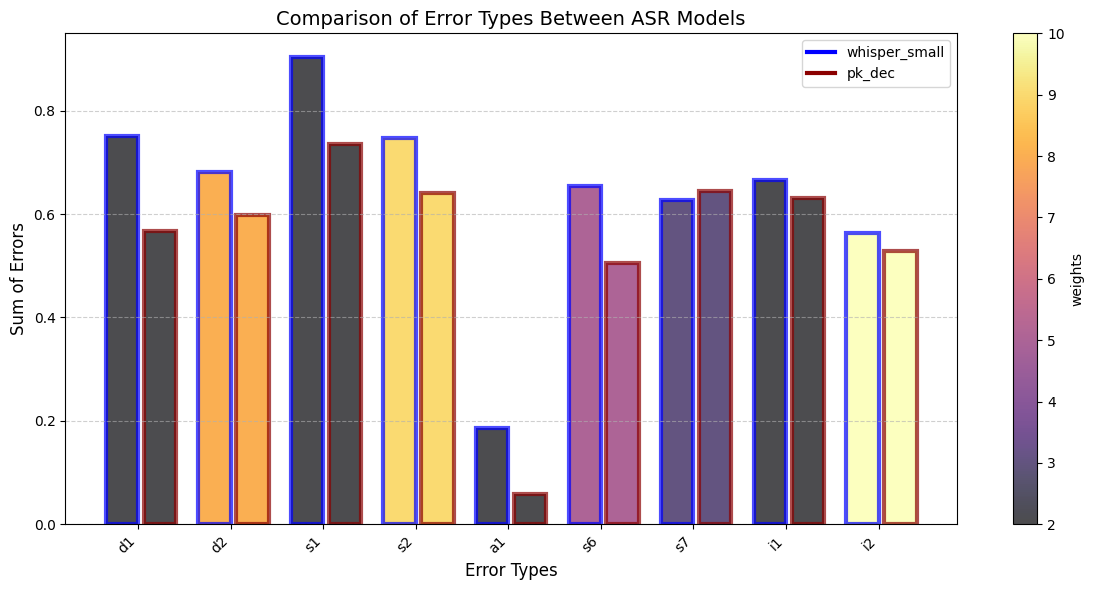

In [45]:
import numpy as np
import matplotlib.pyplot as plt

# Visualization: Bar Plot
x = np.arange(len(error_types))
width = 0.35
lw = 3

# Normalize the weights to a range of 0 to 1 (for colormap)
norm = plt.Normalize(min(weights.values()), max(weights.values()))
colors = plt.cm.inferno(norm(list(weights.values())))  # "inferno" Colormap

epsilon = 0.06

# Erzeuge Figure und Axes
fig, ax = plt.subplots(figsize=(12, 6))

# Zeichne die Balken auf das Axes-Objekt
ax.bar(
    x - width/2,
    model_1_scores,
    width,
    label='Model 1',
    edgecolor='blue',
    linewidth=lw,
    alpha=0.7,
    color=colors
)

ax.bar(
    x + width/2 + epsilon,
    model_2_scores,
    width,
    label='Model 2',
    edgecolor='darkred',
    linewidth=lw,
    alpha=0.7,
    color=colors
)

# Erzeuge eine Colorbar und "binde" sie an die Achse ax
sm = plt.cm.ScalarMappable(cmap='inferno', norm=norm)
sm.set_array([])  # ben√∂tigt f√ºr die Colorbar
cbar = fig.colorbar(sm, ax=ax, label='weights', alpha=0.7)

# Achsenbeschriftungen, Titel und Ticks
ax.set_xlabel('Error Types', fontsize=12)
ax.set_ylabel('Sum of Errors', fontsize=12)
ax.set_title('Comparison of Error Types Between ASR Models', fontsize=14)
ax.set_xticks(x)
ax.set_xticklabels(error_types, rotation=45, ha='right', fontsize=10)

# Legend-Handles (nur Randfarbe sichtbar)
legend_handles = [
    plt.Line2D([0], [0], color='blue', linewidth=lw, label=label_model_1),
    plt.Line2D([0], [0], color='darkred', linewidth=lw, label=label_model_2)
]
ax.legend(handles=legend_handles)

# Layout anpassen und Gitter aktivieren
fig.tight_layout()
ax.grid(axis='y', linestyle='--', alpha=0.6)

# Plot anzeigen
plt.show()

In [46]:
model_1_scores

[np.float64(0.7509276100400146),
 np.float64(0.6816430388949473),
 np.float64(0.9042406669083002),
 np.float64(0.7472503617945008),
 np.float64(0.18681238615664844),
 np.float64(0.654032258064516),
 np.float64(0.6274495412844037),
 np.float64(0.6648550724637681),
 np.float64(0.5633030852994556)]

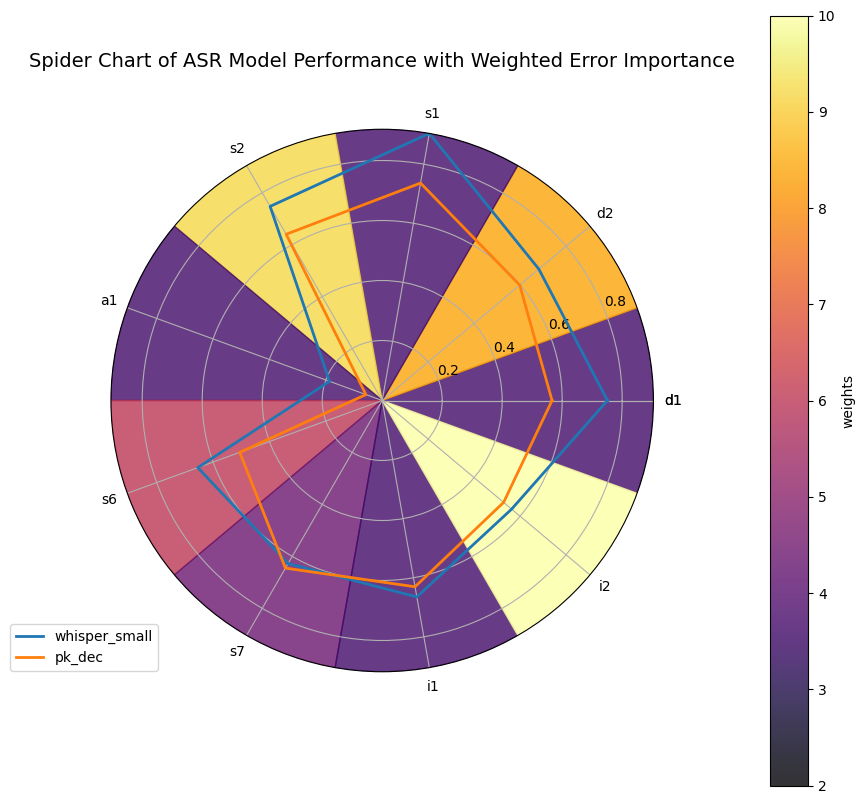

In [47]:
from math import pi
from matplotlib.patches import Rectangle
from math import degrees
# Adjusting for proper alignment between angles and categories
# Close the loop for angles and categories correctly

angles = [n / float(len(error_types)) * 2 * pi for n in range(len(error_types))]
angles += angles[:1]  # Close the loop for angles

categories = error_types + [error_types[0]]# Use all categories including the loop closure

model_1_scores_ = model_1_scores + [model_1_scores[0]]  # Closing the loop for spider chart
model_2_scores_ = model_2_scores + [model_2_scores[0]]
max_score = max(max(model_2_scores),max(model_1_scores))

# Normalize weights for background color intensity (0 to 1 scale)
normalized_weights = np.array(list(weights.values())) / max(weights.values())

# Initialize spider chart
fig, ax = plt.subplots(figsize=(10, 10), subplot_kw=dict(polar=True))

# Background color based on weights
delta_angles = 1*(angles[2]-angles[1])*0.5
# for i in range(len(normalized_weights) - 1):  # Avoid closing loop element for background
#     ax.fill_between(
#         [angles[i]+delta_angles, angles[i + 1]+delta_angles],
#         0,
#         max_score,
#         color=plt.cm.inferno(normalized_weights[i]),
#         alpha=0.2,
#     )
# Draw wedges
for i in range(len(normalized_weights) ):
    # Calculate start and end angles in degrees
    start_angle = angles[i] - delta_angles
    end_angle = 2*delta_angles #angles[i + 1] #+ delta_angles
#     print(start_angle)
#     print(end_angle)
    # Create and add the wedge
    rect = Rectangle((start_angle, max_score), end_angle, max_score*(-1), color=plt.cm.inferno(normalized_weights[i]),alpha=0.8)
#     wedge = Wedge(
#         center=(0, 0),  # Center of the circle
#         r=10,  # Outer radius
#         theta1=0, #start_angle,  # Start angle in degrees
#         theta2=360, #end_angle,  # End angle in degrees
#         color=plt.cm.inferno(normalized_weights[i]),  # Fill color
#         alpha=0.2  # Transparency
#     )
    ax.add_patch(rect)
# ax.scatter(0,0)
ax.set_ylim(0, max_score)

# Add a colorbar to show the mapping
sm = plt.cm.ScalarMappable(cmap='inferno', norm=norm)
sm.set_array([])
#plt.colorbar(sm, label='weights', pad=0.15, alpha=0.8)
fig.colorbar(sm, ax=ax, label='weights', pad=0.15, alpha=0.8)


# Plot data
ax.plot(angles, model_1_scores_, linewidth=2, linestyle='solid', label=label_model_1)
# ax.fill(angles, model_1_scores_, alpha=0.25)

ax.plot(angles, model_2_scores_, linewidth=2, linestyle='solid', label=label_model_2)
# ax.fill(angles, model_2_scores_, alpha=0.25)

# Add category labels
# ax.set_yticks([])  # Hide radial axis labels

ax.set_xticks(angles)  # Adjust for closing loop
ax.set_xticklabels(categories, fontsize=10, ha='center', va='center', rotation=45)

# Title and legend
plt.title("Spider Chart of ASR Model Performance with Weighted Error Importance", size=14, y=1.1)
plt.legend(loc='upper right', bbox_to_anchor=(0.1, 0.1))

plt.show()


In [48]:
weights

{'d1': 2,
 'd2': 8,
 's1': 2,
 's2': 9,
 'a1': 2,
 's6': 5,
 's7': 3,
 'i1': 2,
 'i2': 10}

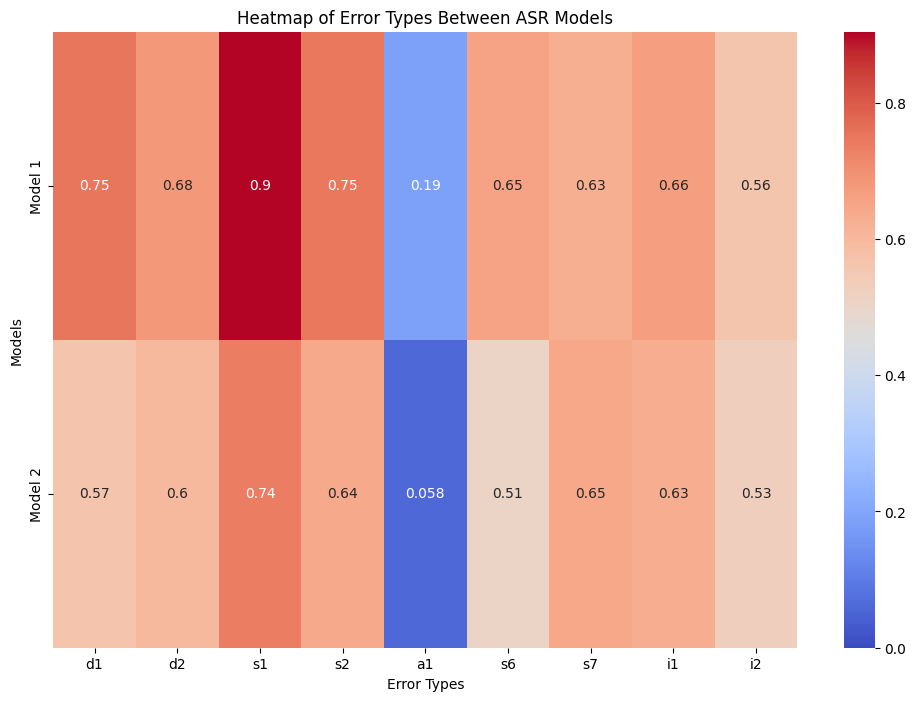

In [49]:
import seaborn as sns
import matplotlib.pyplot as plt

# Combine the data for both models into a single DataFrame
df_combined = pd.DataFrame({
    'Error Type': error_types,
    'Model 1': model_1_scores,
    'Model 2': model_2_scores
})

# Set 'Error Type' as the index
df_combined.set_index('Error Type', inplace=True)

# Plot the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(df_combined.T, annot=True, cmap='coolwarm', vmin=0, vmax=df_combined.max().max())
plt.title('Heatmap of Error Types Between ASR Models')
plt.xlabel('Error Types')
plt.ylabel('Models')
plt.show()

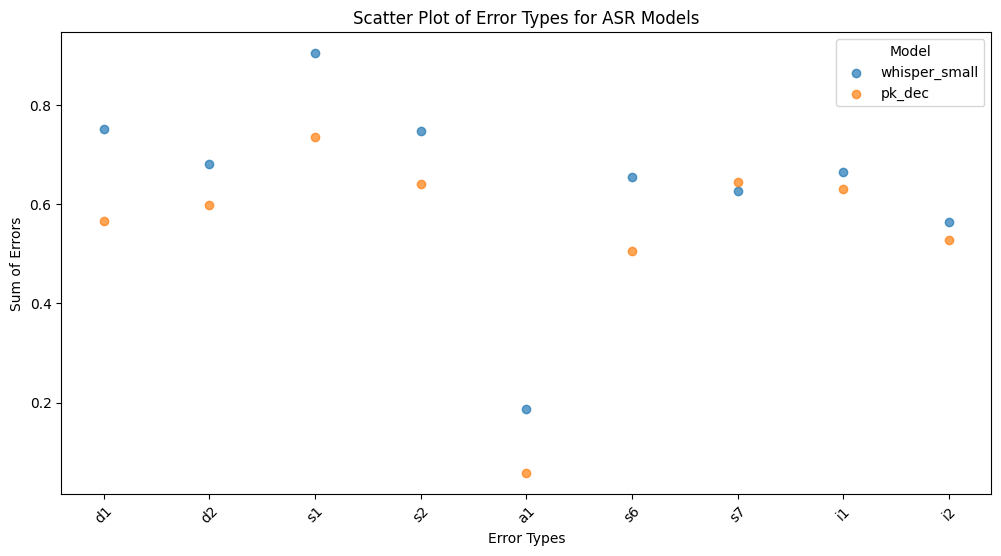

In [50]:
import matplotlib.pyplot as plt

# Combine the data for both models into a single DataFrame
df_combined = pd.DataFrame({
    'Error Type': error_types * 2,
    'Error Value': model_1_scores + model_2_scores,
    'Model': [label_model_1] * len(error_types) + [label_model_2] * len(error_types)
})

# Plot the scatter plot
plt.figure(figsize=(12, 6))
for model in df_combined['Model'].unique():
    subset = df_combined[df_combined['Model'] == model]
    plt.scatter(subset['Error Type'], subset['Error Value'], label=model, alpha=0.7)

plt.xlabel('Error Types')
plt.ylabel('Sum of Errors')
plt.title('Scatter Plot of Error Types for ASR Models')
plt.xticks(rotation=45)
plt.legend(title='Model')
plt.show()

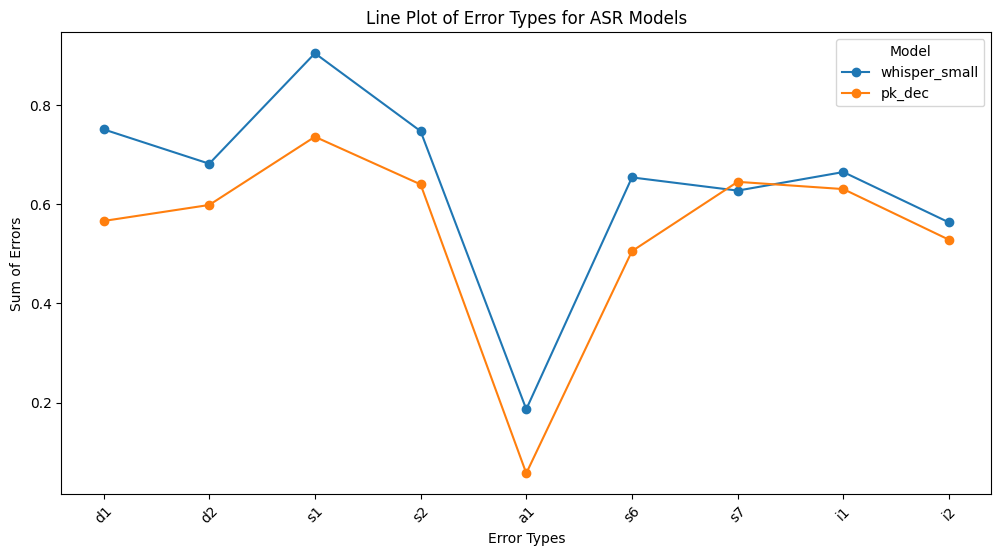

In [51]:
plt.figure(figsize=(12, 6))
plt.plot(error_types, model_1_scores, marker='o', label=label_model_1)
plt.plot(error_types, model_2_scores, marker='o', label=label_model_2)
plt.xlabel('Error Types')
plt.ylabel('Sum of Errors')
plt.title('Line Plot of Error Types for ASR Models')
plt.xticks(rotation=45)
plt.legend(title='Model')
plt.show()

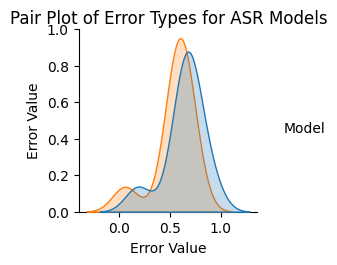

In [52]:
import seaborn as sns

# Combine the data for both models into a single DataFrame
df_combined = pd.DataFrame({
    'Error Type': error_types * 2,
    'Error Value': model_1_scores + model_2_scores,
    'Model': [label_model_1] * len(error_types) + [label_model_2] * len(error_types)
})

# Plot the pair plot
sns.pairplot(df_combined, hue='Model')
plt.suptitle('Pair Plot of Error Types for ASR Models', y=1.02)
plt.show()

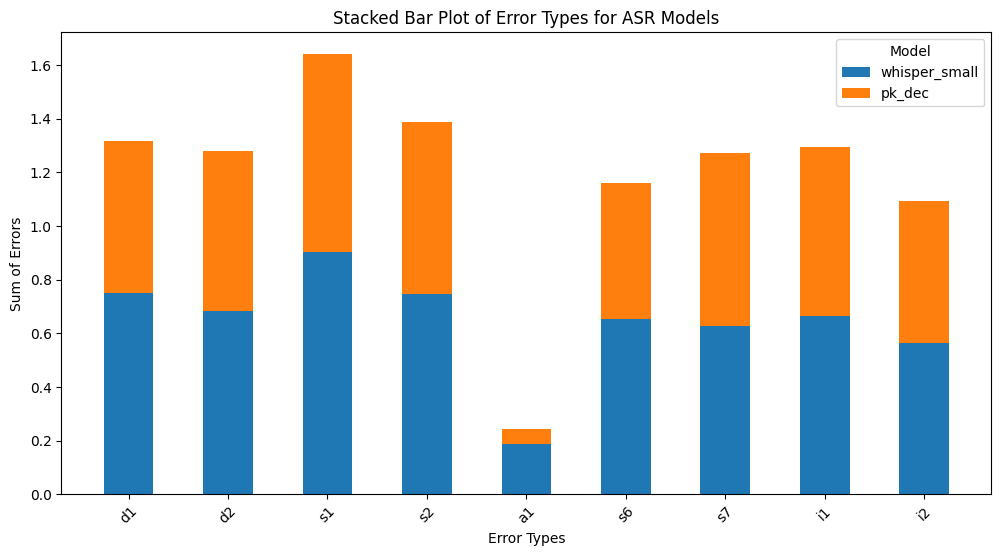

In [53]:
import matplotlib.pyplot as plt
import numpy as np

# Combine the data for both models into a single DataFrame
df_combined = pd.DataFrame({
    'Error Type': error_types,
    label_model_1: model_1_scores,
    label_model_2: model_2_scores
})

# Plot the stacked bar plot
x = np.arange(len(error_types))
width = 0.5

plt.figure(figsize=(12, 6))
plt.bar(x, df_combined[label_model_1], width, label=label_model_1)
plt.bar(x, df_combined[label_model_2], width, bottom=df_combined[label_model_1], label=label_model_2)
plt.xlabel('Error Types')
plt.ylabel('Sum of Errors')
plt.title('Stacked Bar Plot of Error Types for ASR Models')
plt.xticks(x, error_types, rotation=45)
plt.legend(title='Model')
plt.show()

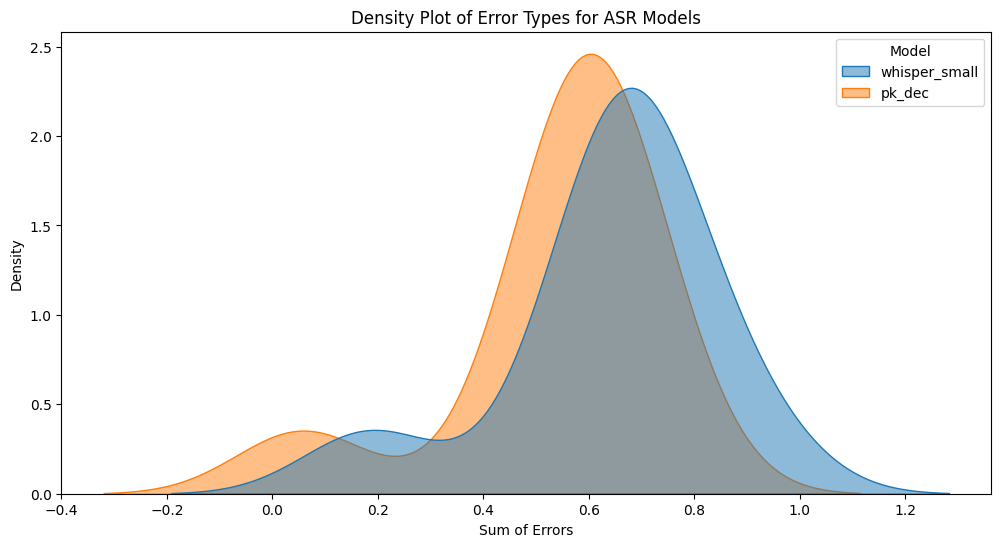

In [54]:
import seaborn as sns
import matplotlib.pyplot as plt

# Combine the data for both models into a single DataFrame
df_combined = pd.DataFrame({
    'Error Type': error_types * 2,
    'Error Value': model_1_scores + model_2_scores,
    'Model': [label_model_1] * len(error_types) + [label_model_2] * len(error_types)
})

# Plot the density plot
plt.figure(figsize=(12, 6))
sns.kdeplot(data=df_combined, x='Error Value', hue='Model', fill=True, common_norm=False, alpha=0.5)
plt.xlabel('Sum of Errors')
plt.ylabel('Density')
plt.title('Density Plot of Error Types for ASR Models')
plt.show()

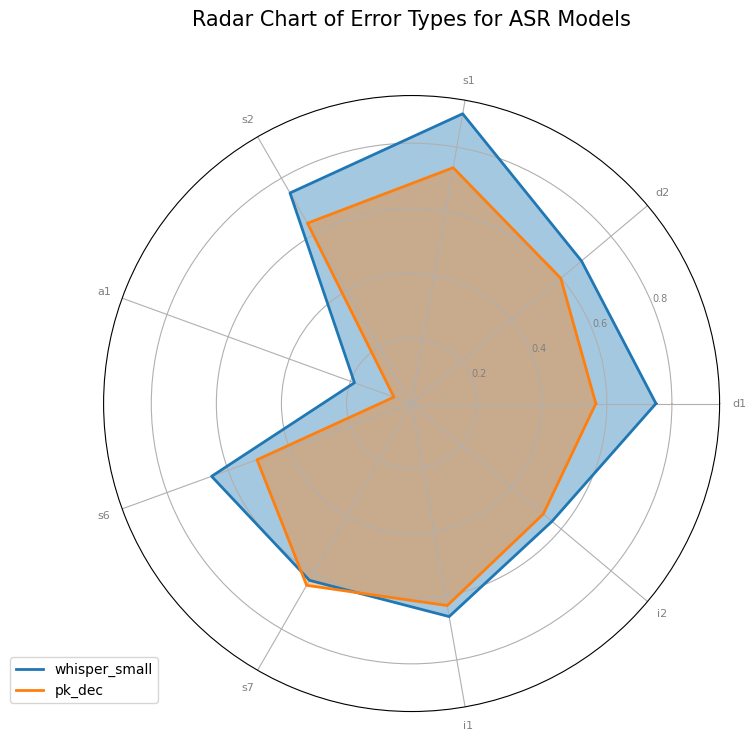

In [55]:
import matplotlib.pyplot as plt
import numpy as np

# Combine the data for both models into a single DataFrame
df_combined = pd.DataFrame({
    'Error Type': error_types,
    label_model_1: model_1_scores,
    label_model_2: model_2_scores
})

# Number of variables
categories = list(df_combined['Error Type'])
N = len(categories)

# What will be the angle of each axis in the plot? (we divide the plot / number of variables)
angles = [n / float(N) * 2 * np.pi for n in range(N)]
angles += angles[:1]

# Initialise the spider plot
fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(polar=True))

# First model
values = df_combined[label_model_1].tolist()
values += values[:1]
ax.plot(angles, values, linewidth=2, linestyle='solid', label=label_model_1)
ax.fill(angles, values, alpha=0.4)

# Second model
values = df_combined[label_model_2].tolist()
values += values[:1]
ax.plot(angles, values, linewidth=2, linestyle='solid', label=label_model_2)
ax.fill(angles, values, alpha=0.4)

# Add labels
plt.xticks(angles[:-1], categories, color='grey', size=8)
plt.yticks(color='grey', size=7)
plt.title('Radar Chart of Error Types for ASR Models', size=15, color='black', y=1.1)
plt.legend(loc='upper right', bbox_to_anchor=(0.1, 0.1))

plt.show()

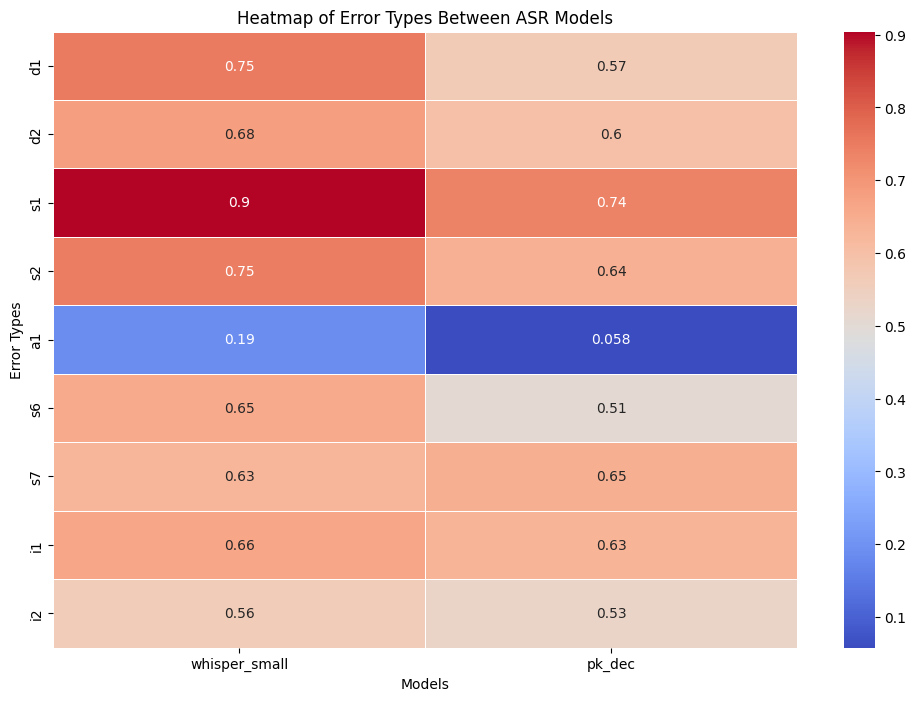

In [56]:
import seaborn as sns
import matplotlib.pyplot as plt

# Combine the data for both models into a single DataFrame
df_combined = pd.DataFrame({
    'Error Type': error_types,
    label_model_1: model_1_scores,
    label_model_2: model_2_scores
})

# Set 'Error Type' as the index
df_combined.set_index('Error Type', inplace=True)

# Plot the heatmap with annotations
plt.figure(figsize=(12, 8))
sns.heatmap(df_combined, annot=True, cmap='coolwarm', linewidths=.5)
plt.title('Heatmap of Error Types Between ASR Models')
plt.xlabel('Models')
plt.ylabel('Error Types')
plt.show()

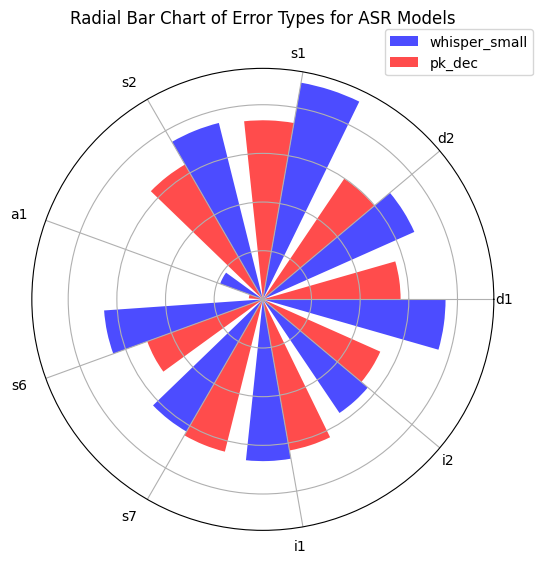

In [57]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Beispiel-Daten (passen Sie Fehlerarten und Score-Variablen an)
df_radial = pd.DataFrame({
    'Error Type': error_types,
    label_model_1: model_1_scores,
    label_model_2: model_2_scores
})

# Anzahl der Error Types
N = len(df_radial)
# Winkel gleichm√§√üig √ºber 0 bis 2œÄ verteilen
theta = np.linspace(0, 2*np.pi, N, endpoint=False)

# Breite f√ºr jeden Balken festlegen (z.B. 40% des Segments)
width = (2*np.pi / N) * 0.4

fig, ax = plt.subplots(figsize=(8, 6), subplot_kw={'projection': 'polar'})

# Plot f√ºr Model 1
bars1 = ax.bar(
    theta - width/2,                   # Leicht nach links versetzt
    df_radial[label_model_1],
    width=width,
    alpha=0.7,
    color='blue',
    label=label_model_1
)

# Plot f√ºr Model 2
bars2 = ax.bar(
    theta + width/2,                   # Leicht nach rechts versetzt
    df_radial[label_model_2],
    width=width,
    alpha=0.7,
    color='red',
    label=label_model_2
)

# Setze die Positionen und Labels auf dem Polar-Achsen
ax.set_xticks(theta)
ax.set_xticklabels(df_radial['Error Type'], rotation=45, ha='right')

ax.set_yticklabels([])
ax.set_title('Radial Bar Chart of Error Types for ASR Models', y=1.08)
ax.legend(loc='upper right', bbox_to_anchor=(1.1, 1.1))

plt.show()

/var/folders/mg/pmqwc7qx23b0bppw1k_4430w0000gq/T/ipykernel_10694/1100899614.py:76: UserWarning:

Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.



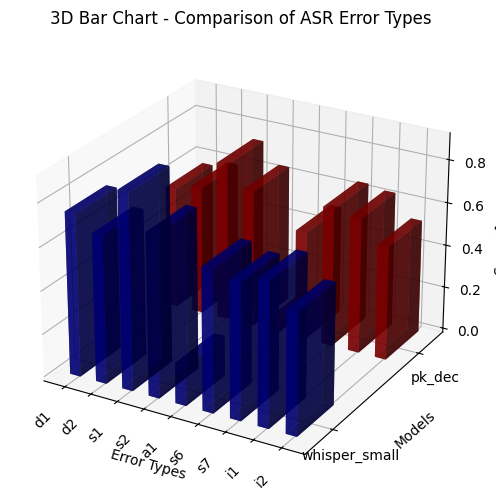

In [58]:
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.mplot3d import Axes3D

# Beispiel: 3D-Bar-Chart, um die Unterschiede zwischen zwei ASR-Modellen detailliert darzustellen

# Erstelle ein DataFrame oder arbeite direkt mit Arrays/Listern
# Wir gehen davon aus, dass Sie Folgendes bereits in Ihrem Workspace definiert haben:
# error_types: Liste von Fehlerarten (Strings)
# model_1_scores: Scores f√ºr Modell 1
# model_2_scores: Scores f√ºr Modell 2
# label_model_1, label_model_2: Namen der beiden Modelle

# Anzahl der Error Types
n = len(error_types)
x = np.arange(n)  # x-Positionen f√ºr die Kategorien (Error Types)

# Wir legen zwei y-Werte f√ºr die Modelle fest (0 und 1)
y_model_1 = np.zeros(n)    # y=0 f√ºr Modell 1
y_model_2 = np.ones(n)     # y=1 f√ºr Modell 2

# H√∂he (dz) = Score
z_model_1 = model_1_scores
z_model_2 = model_2_scores

# 3D-Plot vorbereiten
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, projection='3d')

# Balken-Dimension f√ºr x und y
dx = 0.4
dy = 0.4

# Plot f√ºr Modell 1
for i in range(n):
    ax.bar3d(
        x[i],              # x-Start
        y_model_1[i],      # y-Start
        0,                 # z-Start (Basis)
        dx,                # Breite in x-Richtung
        dy,                # Breite in y-Richtung
        z_model_1[i],      # H√∂he (Score)
        color='navy',
        alpha=0.7
    )

# Plot f√ºr Modell 2
for i in range(n):
    ax.bar3d(
        x[i],              # x-Start
        y_model_2[i],      # y-Start
        0,                 # z-Start (Basis)
        dx,                # Breite in x-Richtung
        dy,                # Breite in y-Richtung
        z_model_2[i],      # H√∂he (Score)
        color='darkred',
        alpha=0.7
    )

# Achsen beschriften und Ticks setzen
ax.set_xlabel('Error Types')
ax.set_ylabel('Models')
ax.set_zlabel('Sum of Errors')
ax.set_title('3D Bar Chart - Comparison of ASR Error Types')

ax.set_xticks(x + dx/2)
ax.set_xticklabels(error_types, rotation=45, ha='right')

# Y-Achse so platzieren, dass man die Modelle unterscheiden kann (0 und 1)
ax.set_yticks([0 + dy/2, 1 + dy/2])
ax.set_yticklabels([label_model_1, label_model_2])

# Optional: Betrachterwinkel anpassen
ax.view_init(elev=25, azim=-60)

plt.tight_layout()
plt.show()

/var/folders/mg/pmqwc7qx23b0bppw1k_4430w0000gq/T/ipykernel_10694/116998835.py:50: UserWarning:

Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.



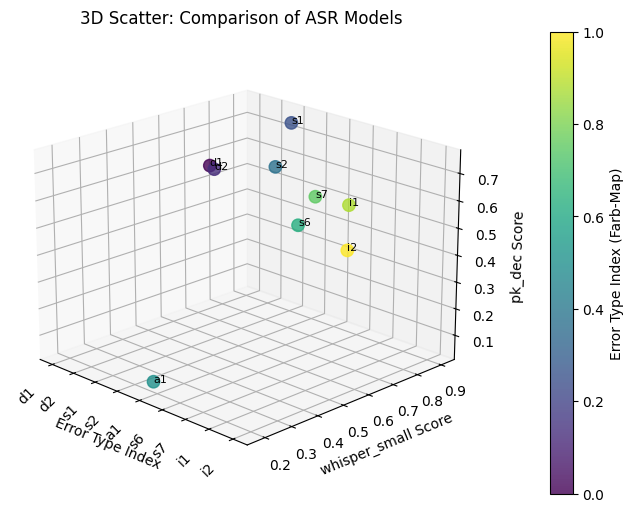

In [59]:
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.mplot3d import Axes3D

# Wir gehen davon aus, dass folgende Variablen bekannt sind:
# error_types: Liste von Fehlerarten (Strings)
# model_1_scores: Scores (Liste/Array) f√ºr Modell 1
# model_2_scores: Scores (Liste/Array) f√ºr Modell 2
# label_model_1, label_model_2: Bezeichnungen der Modelle

# Anzahl der Error Types
n = len(error_types)

# x ist der Index f√ºr Error Types
x = np.arange(n)

# y und z entsprechen den jeweiligen Modell-Scores
y = model_1_scores
z = model_2_scores

fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, projection='3d')

# 3D-Scatter-Plot
# Wir f√§rben jeden Punkt anders, damit sie deutlicher hervortreten.
colors = np.linspace(0, 1, n)
scatter = ax.scatter(x, y, z, c=colors, cmap='viridis', s=80, alpha=0.8)

# Achsen beschriften
ax.set_xlabel('Error Type Index')
ax.set_ylabel(f'{label_model_1} Score')
ax.set_zlabel(f'{label_model_2} Score')
ax.set_title('3D Scatter: Comparison of ASR Models')

# Ticks & Labels f√ºr die x-Achse auf die Fehlerarten setzen
ax.set_xticks(x)
ax.set_xticklabels(error_types, rotation=45, ha='right')

# Optional: Punkte beschriften (Error Types) - kann bei vielen Kategorien un√ºbersichtlich werden
for i in range(n):
    ax.text(x[i], y[i], z[i], error_types[i], size=8, color='black')

# Blickwinkel anpassen (optional)
ax.view_init(elev=20, azim=-45)

# Farbleiste hinzuf√ºgen
cbar = plt.colorbar(scatter, pad=0.1)
cbar.set_label('Error Type Index (Farb-Map)')

plt.tight_layout()
plt.show()

/var/folders/mg/pmqwc7qx23b0bppw1k_4430w0000gq/T/ipykernel_10694/2812712370.py:55: UserWarning:

Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.



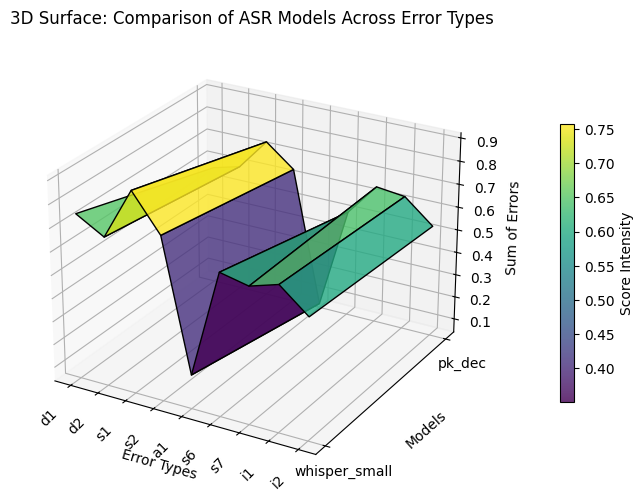

In [60]:
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.mplot3d import Axes3D

# Wir gehen davon aus, dass folgende Variablen schon in Ihrem Notebook definiert sind:
# error_types: Liste mit den Kategorien, z.B. ["Error1", "Error2", ...]
# model_1_scores: Scores (Liste/Array) f√ºr Modell 1
# model_2_scores: Scores (Liste/Array) f√ºr Modell 2
# label_model_1 und label_model_2: Bezeichnungen f√ºr die Modelle

n = len(error_types)

# X-Achse: Index f√ºr die Fehlerarten
x_range = np.arange(n)

# Y-Achse: Zwei 'Model-Indices' (0 = Modell1, 1 = Modell2)
y_range = np.array([0, 1])

# Erstelle ein Meshgrid f√ºr das Surface (2 x n)
X, Y = np.meshgrid(x_range, y_range)  # X.shape=(2,n), Y.shape=(2,n)

# Z-Werte in gleicher Dimension (2 x n)
Z = np.zeros_like(X, dtype=float)
for i in range(n):
    Z[0, i] = model_1_scores[i]  # Modell 1
    Z[1, i] = model_2_scores[i]  # Modell 2

fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, projection='3d')

# Surface-Plot
surface = ax.plot_surface(X, Y, Z, cmap='viridis', edgecolor='k', alpha=0.8)

# Achsenbeschriftungen
ax.set_xlabel('Error Types')
ax.set_ylabel('Models')
ax.set_zlabel('Sum of Errors')
ax.set_title('3D Surface: Comparison of ASR Models Across Error Types')

# X-Ticks: Fehlerarten
ax.set_xticks(x_range)
ax.set_xticklabels(error_types, rotation=45, ha='right')

# Y-Ticks: Modelle
ax.set_yticks([0, 1])
ax.set_yticklabels([label_model_1, label_model_2])

# Farbleiste f√ºr die Werte
cbar = plt.colorbar(surface, shrink=0.6, pad=0.1)
cbar.set_label('Score Intensity')

# Leichtes Anpassen des Betrachtungswinkels
ax.view_init(elev=25, azim=-60)

plt.tight_layout()
plt.show()

/var/folders/mg/pmqwc7qx23b0bppw1k_4430w0000gq/T/ipykernel_10694/936390025.py:60: UserWarning:

Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.



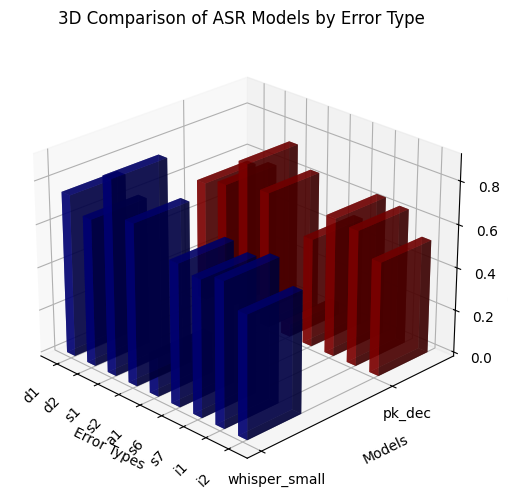

In [61]:
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.mplot3d import Axes3D

# Wir nehmen an, dass Sie bereits folgende Variablen definiert haben:
# error_types: Liste mit den Kategorien, z.B. ["Error1", "Error2", ...]
# model_1_scores: Scores (Liste/Array) f√ºr Modell 1
# model_2_scores: Scores (Liste/Array) f√ºr Modell 2
# label_model_1 und label_model_2: Labels (Strings) f√ºr die beiden Modelle

fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, projection='3d')

x_positions = np.arange(len(error_types))  # x-Koordinaten f√ºr die einzelnen Error Types
y_positions = [0, 1]                       # y-Koordinaten: 0 = Modell1, 1 = Modell2

dx = 0.4  # Balkenbreite in x-Richtung
dy = 0.4  # Balkenbreite in y-Richtung

for i, etype in enumerate(error_types):
    # 3D-Balken f√ºr Modell 1
    ax.bar3d(
        x_positions[i],  # Start in x
        y_positions[0],  # Start in y
        0,               # Basis-H√∂he
        dx,
        dy,
        model_1_scores[i],   # H√∂he = Score von Modell 1
        color='navy',
        alpha=0.7
    )
    # 3D-Balken f√ºr Modell 2
    ax.bar3d(
        x_positions[i],  
        y_positions[1],
        0,
        dx,
        dy,
        model_2_scores[i],   # H√∂he = Score von Modell 2
        color='darkred',
        alpha=0.7
    )

# X-Achse: Error Types
ax.set_xticks(x_positions + dx/2)
ax.set_xticklabels(error_types, rotation=45, ha='right')
ax.set_xlabel('Error Types')

# Y-Achse: Modelle
ax.set_yticks(y_positions)
ax.set_yticklabels([label_model_1, label_model_2])
ax.set_ylabel('Models')

# Z-Achse
ax.set_zlabel('Sum of Errors')

ax.set_title('3D Comparison of ASR Models by Error Type')
ax.view_init(elev=25, azim=-45)

plt.tight_layout()
plt.show()

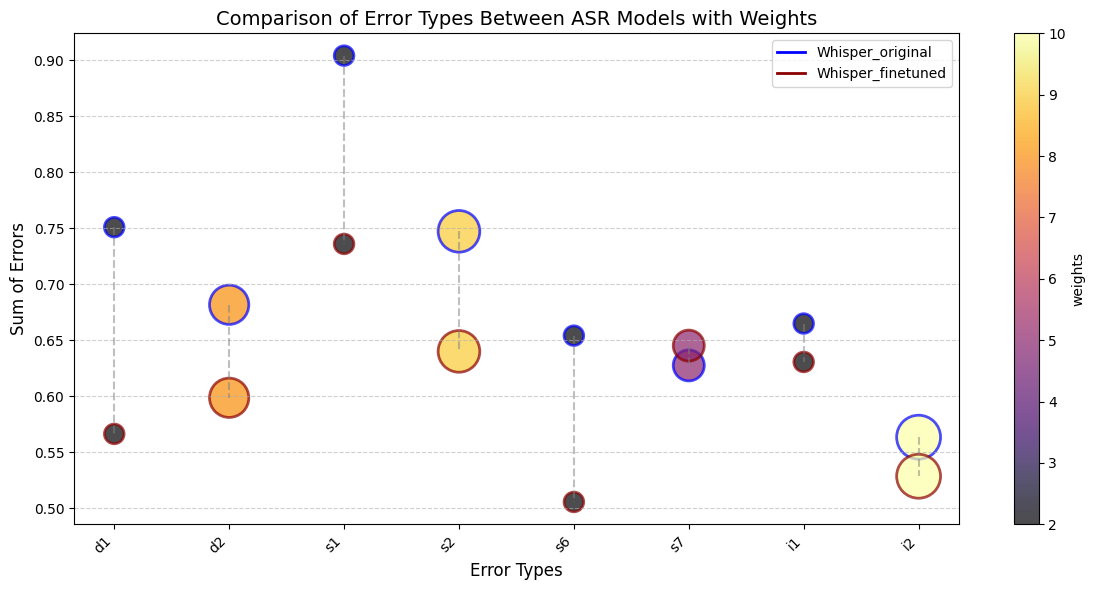

In [64]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Korrigiere: 'a1' existiert nicht in df_error_types['tag'], daher filtern wir error_types so,
# dass nur Tags verwendet werden, die auch im DataFrame vorhanden sind:
error_types_filtered = [et for et in error_types if et in df_error_types['tag'].unique()]

label_model_1 = "Whisper_original"
label_model_2 = "Whisper_finetuned"

df_error_types['Relevanz'] = pd.to_numeric(df_error_types['Relevanz'], errors='coerce')
weights_dict = df_error_types.set_index('tag')['Relevanz'].to_dict()

weight_values = [weights_dict[et] for et in error_types_filtered]

x_vals = np.arange(len(error_types_filtered))
y_model_1 = np.array([model_1_scores[error_types.index(et)] for et in error_types_filtered])
y_model_2 = np.array([model_2_scores[error_types.index(et)] for et in error_types_filtered])

norm = plt.Normalize(min(weight_values), max(weight_values))
colors = plt.cm.inferno(norm(weight_values))

fig, ax = plt.subplots(figsize=(12, 6))

sizes = np.array(weight_values) * 100

scatter1 = ax.scatter(x_vals, y_model_1, s=sizes, c=colors,
                      label=label_model_1, alpha=0.7, edgecolor='blue', linewidth=2)

scatter2 = ax.scatter(x_vals, y_model_2, s=sizes, c=colors,
                      label=label_model_2, alpha=0.7, edgecolor='darkred', linewidth=2)

for i in range(len(error_types_filtered)):
    ax.plot([x_vals[i], x_vals[i]], [y_model_1[i], y_model_2[i]],
            color='gray', linestyle='--', alpha=0.5)

sm = plt.cm.ScalarMappable(cmap='inferno', norm=norm)
sm.set_array([])
cbar = fig.colorbar(sm, ax=ax, label='weights', alpha=0.7)

ax.set_xlabel('Error Types', fontsize=12)
ax.set_ylabel('Sum of Errors', fontsize=12)
ax.set_title('Comparison of Error Types Between ASR Models with Weights', fontsize=14)
ax.set_xticks(x_vals)
ax.set_xticklabels(error_types_filtered, rotation=45, ha='right', fontsize=10)

legend_handles = [
    plt.Line2D([0], [0], color='blue', linewidth=2, label=label_model_1),
    plt.Line2D([0], [0], color='darkred', linewidth=2, label=label_model_2)
]
ax.legend(handles=legend_handles)

fig.tight_layout()
ax.grid(axis='y', linestyle='--', alpha=0.6)
plt.show()



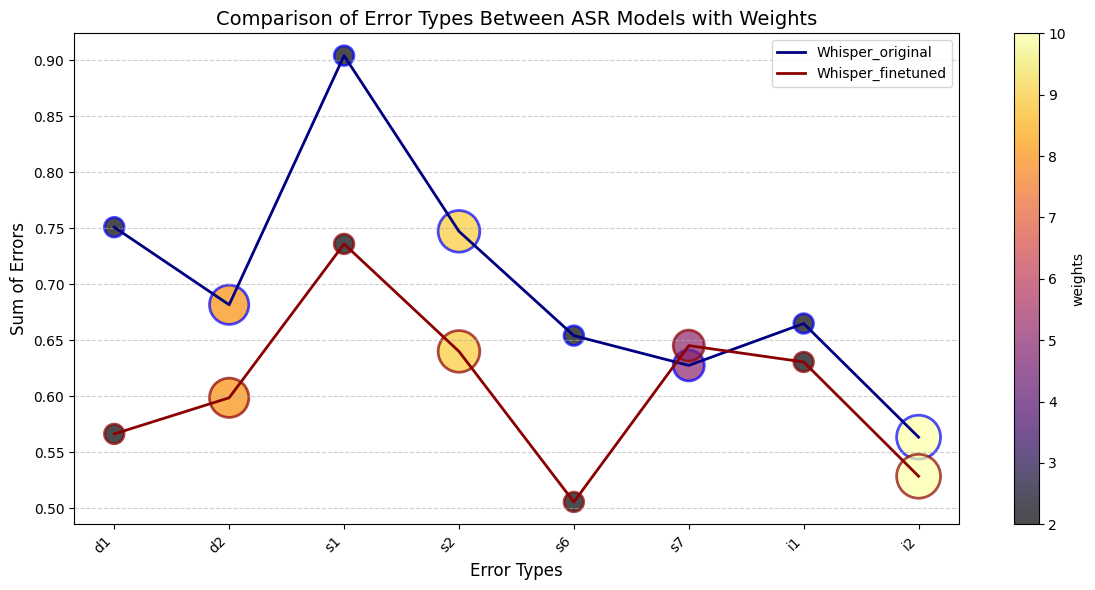

In [67]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Filter, sodass nur Tags verwendet werden, die tats√§chlich in df_error_types stehen
error_types_filtered = [et for et in error_types if et in df_error_types['tag'].unique()]

# Relevanz in float konvertieren
df_error_types['Relevanz'] = pd.to_numeric(df_error_types['Relevanz'], errors='coerce')
weights_dict = df_error_types.set_index('tag')['Relevanz'].to_dict()

# Erzeuge die Gewichtswerte in Reihenfolge der gefilterten error_types
weight_values_filtered = [weights_dict[et] for et in error_types_filtered]

# X-Achse und Y-Werte an die gefilterte L√§nge anpassen
x_vals = np.arange(len(error_types_filtered))

# Y-Werte passend filtern (hier wird angenommen, dass model_1_scores / model_2_scores
# in derselben Reihenfolge stehen wie error_types ‚Äì ggf. anpassen, falls unterschiedliche Reihenfolgen)
model_1_dict = dict(zip(error_types, model_1_scores))
model_2_dict = dict(zip(error_types, model_2_scores))
y_model_1_filtered = np.array([model_1_dict[et] for et in error_types_filtered])
y_model_2_filtered = np.array([model_2_dict[et] for et in error_types_filtered])

# Normalisierung f√ºr die Farbskala
norm = plt.Normalize(min(weight_values_filtered), max(weight_values_filtered))
colors = plt.cm.inferno(norm(weight_values_filtered))

fig, ax = plt.subplots(figsize=(12, 6))

# Punktgr√∂√üen
sizes = np.array(weight_values_filtered) * 100

# Linienplots
ax.plot(x_vals, y_model_1_filtered, color='navy', linewidth=2, label=label_model_1)
ax.plot(x_vals, y_model_2_filtered, color='darkred', linewidth=2, label=label_model_2)

# Scatterplots
scatter1 = ax.scatter(x_vals, y_model_1_filtered, s=sizes, c=colors,
                      alpha=0.7, edgecolor='blue', linewidth=2, label=label_model_1)
scatter2 = ax.scatter(x_vals, y_model_2_filtered, s=sizes, c=colors,
                      alpha=0.7, edgecolor='darkred', linewidth=2, label=label_model_2)

# Colorbar
sm = plt.cm.ScalarMappable(cmap='inferno', norm=norm)
sm.set_array([])
cbar = fig.colorbar(sm, ax=ax, label='weights', alpha=0.7)

ax.set_xlabel('Error Types', fontsize=12)
ax.set_ylabel('Sum of Errors', fontsize=12)
ax.set_title('Comparison of Error Types Between ASR Models with Weights', fontsize=14)
ax.set_xticks(x_vals)
ax.set_xticklabels(error_types_filtered, rotation=45, ha='right', fontsize=10)

legend_handles = [
    plt.Line2D([0], [0], color='navy', linewidth=2, label=label_model_1),
    plt.Line2D([0], [0], color='darkred', linewidth=2, label=label_model_2)
]
ax.legend(handles=legend_handles)

fig.tight_layout()
ax.grid(axis='y', linestyle='--', alpha=0.6)
plt.show()



In [69]:
from bokeh.plotting import figure, show, output_notebook
from bokeh.models import ColumnDataSource, ColorBar, LinearColorMapper
from bokeh.transform import linear_cmap
from bokeh.layouts import gridplot

import numpy as np

output_notebook()

# Filter error_types so we only keep keys that exist in error_weights
filtered_error_types = [et for et in error_types if et in error_weights]

# Neue L√§nge und X-Achse
n = len(filtered_error_types)
x_vals = np.arange(n)

# Y-Werte passend zur gefilterten Liste ermitteln
# (Wir gehen davon aus, dass model_1_scores/model_2_scores in derselben Reihenfolge stehen wie error_types)
y_model_1 = np.array([model_1_scores[error_types.index(et)] for et in filtered_error_types])
y_model_2 = np.array([model_2_scores[error_types.index(et)] for et in filtered_error_types])

# Gewichtungen passend zur gefilterten Liste
weights = np.array([error_weights[et] for et in filtered_error_types])

source = ColumnDataSource(data=dict(
    x=x_vals,
    y_model_1=y_model_1,
    y_model_2=y_model_2,
    weights=weights
))

mapper = LinearColorMapper(palette='Inferno256', low=min(weights), high=max(weights))

p1 = figure(title=label_model_1, x_axis_label='Error Types', y_axis_label='Sum of Errors')
p1.circle('x', 'y_model_1', size='weights', 
          color={'field': 'weights', 'transform': mapper}, 
          source=source, legend_label=label_model_1)

p2 = figure(title=label_model_2, x_axis_label='Error Types', y_axis_label='Sum of Errors')
p2.circle('x', 'y_model_2', size='weights', 
          color={'field': 'weights', 'transform': mapper}, 
          source=source, legend_label=label_model_2)

color_bar = ColorBar(color_mapper=mapper, location=(0, 0))
p1.add_layout(color_bar, 'right')
p2.add_layout(color_bar, 'right')

show(gridplot([[p1, p2]]))


Loading BokehJS ...

In [71]:
import altair as alt
import pandas as pd
import numpy as np

# Filter `error_types` to keep only those available in `error_weights`
filtered_error_types = [et for et in error_types if et in error_weights]

# Create aligned score arrays for the filtered error types
y_model_1_filtered = [model_1_scores[error_types.index(et)] for et in filtered_error_types]
y_model_2_filtered = [model_2_scores[error_types.index(et)] for et in filtered_error_types]

n = len(filtered_error_types)

# Build matching weights array for the filtered types
weights_filtered = [error_weights[et] for et in filtered_error_types]

data = pd.DataFrame({
    'Error Types': np.tile(filtered_error_types, 2),
    'Sum of Errors': np.concatenate([y_model_1_filtered, y_model_2_filtered]),
    'Model': [label_model_1] * n + [label_model_2] * n,
    'Weights': np.tile(weights_filtered, 2)
})

chart = alt.Chart(data).mark_circle().encode(
    x='Error Types',
    y='Sum of Errors',
    size='Weights',
    color='Weights',
    tooltip=['Error Types', 'Sum of Errors', 'Model', 'Weights']
).properties(
    title='Comparison of Error Types Between ASR Models with Weights'
).facet(
    column='Model'
)

chart.show()


alt.FacetChart(...)

In [73]:
import altair as alt
import pandas as pd
import numpy as np

# Filter out error_types that aren't present in error_weights
filtered_error_types = [et for et in error_types if et in error_weights]

# Align scores with the filtered error_types
y_model_1_filtered = [model_1_scores[error_types.index(et)] for et in filtered_error_types]
y_model_2_filtered = [model_2_scores[error_types.index(et)] for et in filtered_error_types]

# Create the filtered weights array
weights_filtered = [error_weights[et] for et in filtered_error_types]

# Create a DataFrame for Altair
n = len(filtered_error_types)
data = pd.DataFrame({
    'Error Types': np.tile(filtered_error_types, 2),
    'Sum of Errors': np.concatenate([y_model_1_filtered, y_model_2_filtered]),
    'Model': [label_model_1] * n + [label_model_2] * n,
    'Weights': np.tile(weights_filtered, 2)
})

chart = alt.Chart(data).mark_circle().encode(
    x='Error Types',
    y='Sum of Errors',
    size='Weights',
    color='Model',
    shape='Model',
    tooltip=['Error Types', 'Sum of Errors', 'Model', 'Weights']
).properties(
    title='Comparison of Error Types Between ASR Models with Weights'
)

chart.show()


alt.Chart(...)

In [76]:
import altair as alt
import pandas as pd
import numpy as np

# Filter out error_types that don't exist in error_weights
filtered_error_types = [et for et in error_types if et in error_weights]

# Align model scores with the filtered error types
y_model_1_filtered = [model_1_scores[error_types.index(et)] for et in filtered_error_types]
y_model_2_filtered = [model_2_scores[error_types.index(et)] for et in filtered_error_types]

# Build the filtered weights array
weights_filtered = [error_weights[et] for et in filtered_error_types]

n = len(filtered_error_types)

data = pd.DataFrame({
    'Error Types': np.tile(filtered_error_types, 2),
    'Sum of Errors': np.concatenate([y_model_1_filtered, y_model_2_filtered]),
    'Model': [label_model_1] * n + [label_model_2] * n,
    'Weights': np.tile(weights_filtered, 2)
})

chart = alt.Chart(data).mark_circle().encode(
    x=alt.X('Error Types', title='Error Types', 
            sort=filtered_error_types,      # Sort by the filtered list
            axis=alt.Axis(labelAngle=-45)),
    y=alt.Y('Sum of Errors', title='Sum of Errors'),
    size=alt.Size('Weights', title='Weights', scale=alt.Scale(range=[100, 1000])),
    color=alt.Color('Model', title='Model'),
    shape=alt.Shape('Model', title='Model'),
    tooltip=['Error Types', 'Sum of Errors', 'Model', 'Weights']
).properties(
    title='Comparison of Error Types Between ASR Models with Weights',
    width=800,
    height=400
).configure_axis(
    labelFontSize=12,
    titleFontSize=14
).configure_legend(
    labelFontSize=12,
    titleFontSize=14
)

chart.show()


alt.Chart(...)

In [78]:
import altair as alt
import pandas as pd
import numpy as np

# Filter out error_types that aren't in error_weights
filtered_error_types = [et for et in error_types if et in error_weights]

# Create aligned arrays for the filtered error types
y_model_1_filtered = [model_1_scores[error_types.index(et)] for et in filtered_error_types]
y_model_2_filtered = [model_2_scores[error_types.index(et)] for et in filtered_error_types]
weights_filtered = [error_weights[et] for et in filtered_error_types]

n = len(filtered_error_types)

# Build DataFrame for Altair
data = pd.DataFrame({
    'Error Types': np.tile(filtered_error_types, 2),
    'Sum of Errors': np.concatenate([y_model_1_filtered, y_model_2_filtered]),
    'Model': [label_model_1] * n + [label_model_2] * n,
    'Weights': np.tile(weights_filtered, 2)
})

line_chart = alt.Chart(data).mark_line(point=True).encode(
    x=alt.X('Error Types:N', title='Error Types', sort=filtered_error_types, axis=alt.Axis(labelAngle=-45)),
    y=alt.Y('Sum of Errors:Q', title='Sum of Errors'),
    color=alt.Color('Model:N', title='Model'),
    tooltip=['Error Types', 'Sum of Errors', 'Model', 'Weights']
).properties(
    title='Line Chart: Comparison of Error Types Between ASR Models',
    width=800,
    height=400
).configure_axis(
    labelFontSize=12,
    titleFontSize=14
).configure_legend(
    labelFontSize=12,
    titleFontSize=14
)

line_chart.show()


alt.Chart(...)

In [80]:
import altair as alt
import pandas as pd
import numpy as np

# Filter out error_types that aren't present in error_weights
filtered_error_types = [et for et in error_types if et in error_weights]

# Create aligned arrays for the filtered list
y_model_1_filtered = [model_1_scores[error_types.index(et)] for et in filtered_error_types]
y_model_2_filtered = [model_2_scores[error_types.index(et)] for et in filtered_error_types]
weights_filtered = [error_weights[et] for et in filtered_error_types]

n = len(filtered_error_types)

# Build DataFrame for Altair
data = pd.DataFrame({
    'Error Types': np.tile(filtered_error_types, 2),
    'Sum of Errors': np.concatenate([y_model_1_filtered, y_model_2_filtered]),
    'Model': [label_model_1] * n + [label_model_2] * n,
    'Weights': np.tile(weights_filtered, 2)
})

line_chart = alt.Chart(data).mark_line(point=True).encode(
    x=alt.X('Error Types:N', 
            title='Error Types', 
            sort=filtered_error_types, 
            axis=alt.Axis(labelAngle=-45)),
    y=alt.Y('Sum of Errors:Q', title='Sum of Errors'),
    color=alt.Color('Model:N', title='Model'),
    tooltip=['Error Types', 'Sum of Errors', 'Model', 'Weights']
).properties(
    title='Line Chart: Comparison of Error Types Between ASR Models',
    width=800,
    height=400
).configure_axis(
    labelFontSize=12,
    titleFontSize=14
).configure_legend(
    labelFontSize=12,
    titleFontSize=14
)

line_chart.show()


alt.Chart(...)

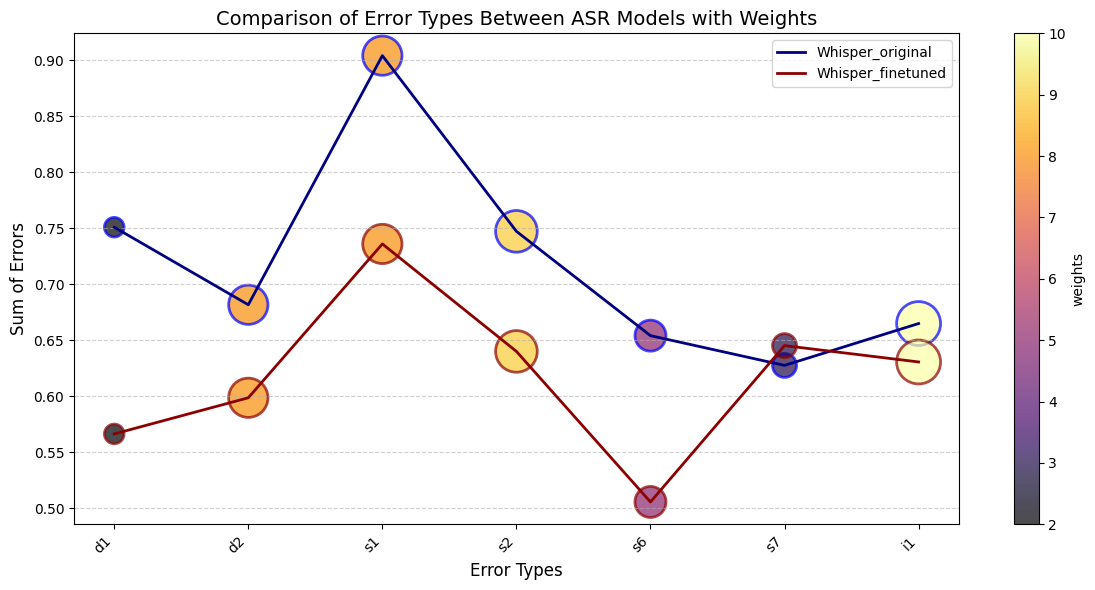

In [82]:
import numpy as np
import matplotlib.pyplot as plt

# Filter out error_types that don't exist in error_weights
filtered_error_types = [et for et in error_types if et in error_weights]

# Neue L√§nge nach dem Filtern
n = len(filtered_error_types)
x_vals = np.arange(n)

# Passende Modell-Scores f√ºr die gefilterten Fehler-Typen
y_model_1_filtered = [model_1_scores[error_types.index(et)] for et in filtered_error_types]
y_model_2_filtered = [model_2_scores[error_types.index(et)] for et in filtered_error_types]

# Gewichte passend zu den gefilterten Fehlern
weights_filtered = [error_weights[et] for et in filtered_error_types]

# Normalize (Colormap)
norm = plt.Normalize(min(weights_filtered), max(weights_filtered))
colors = plt.cm.inferno(norm(weights_filtered))

fig, ax = plt.subplots(figsize=(12, 6))

# Linienplots
ax.plot(x_vals, y_model_1_filtered, color='navy', linewidth=2, label=label_model_1)
ax.plot(x_vals, y_model_2_filtered, color='darkred', linewidth=2, label=label_model_2)

# Scatterplots
scatter1 = ax.scatter(
    x_vals, y_model_1_filtered, 
    s=np.array(weights_filtered) * 100, 
    c=colors, alpha=0.7, edgecolor='blue', linewidth=2
)
scatter2 = ax.scatter(
    x_vals, y_model_2_filtered, 
    s=np.array(weights_filtered) * 100, 
    c=colors, alpha=0.7, edgecolor='darkred', linewidth=2
)

# Colorbar
sm = plt.cm.ScalarMappable(cmap='inferno', norm=norm)
sm.set_array([])
cbar = fig.colorbar(sm, ax=ax, label='weights', alpha=0.7)

ax.set_xlabel('Error Types', fontsize=12)
ax.set_ylabel('Sum of Errors', fontsize=12)
ax.set_title('Comparison of Error Types Between ASR Models with Weights', fontsize=14)
ax.set_xticks(x_vals)
ax.set_xticklabels(filtered_error_types, rotation=45, ha='right', fontsize=10)

legend_handles = [
    plt.Line2D([0], [0], color='navy', linewidth=2, label=label_model_1),
    plt.Line2D([0], [0], color='darkred', linewidth=2, label=label_model_2)
]
ax.legend(handles=legend_handles)

fig.tight_layout()
ax.grid(axis='y', linestyle='--', alpha=0.6)
plt.show()


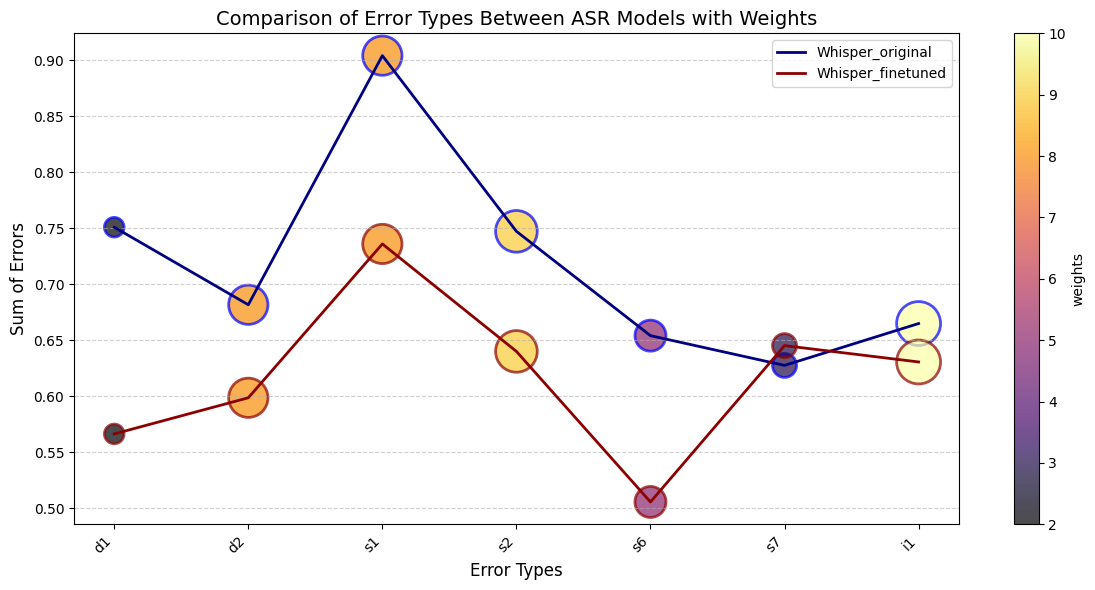

In [84]:
import numpy as np
import matplotlib.pyplot as plt

# Filter only the error types present in error_weights
filtered_error_types = [et for et in error_types if et in error_weights]

# Adjust lengths
n = len(filtered_error_types)
x_vals = np.arange(n)

# Filter model scores accordingly
y_model_1_filtered = [model_1_scores[error_types.index(et)] for et in filtered_error_types]
y_model_2_filtered = [model_2_scores[error_types.index(et)] for et in filtered_error_types]

# Filtered weights
weights_filtered = [error_weights[et] for et in filtered_error_types]

norm = plt.Normalize(min(weights_filtered), max(weights_filtered))
colors = plt.cm.inferno(norm(weights_filtered))

fig, ax = plt.subplots(figsize=(12, 6))

ax.plot(x_vals, y_model_1_filtered, color='navy', linewidth=2, label=label_model_1)
ax.plot(x_vals, y_model_2_filtered, color='darkred', linewidth=2, label=label_model_2)

scatter1 = ax.scatter(
    x_vals, y_model_1_filtered, 
    s=np.array(weights_filtered)*100, 
    c=colors, alpha=0.7, edgecolor='blue', linewidth=2
)
scatter2 = ax.scatter(
    x_vals, y_model_2_filtered, 
    s=np.array(weights_filtered)*100, 
    c=colors, alpha=0.7, edgecolor='darkred', linewidth=2
)

sm = plt.cm.ScalarMappable(cmap='inferno', norm=norm)
sm.set_array([])
cbar = fig.colorbar(sm, ax=ax, label='weights', alpha=0.7)

ax.set_xlabel('Error Types', fontsize=12)
ax.set_ylabel('Sum of Errors', fontsize=12)
ax.set_title('Comparison of Error Types Between ASR Models with Weights', fontsize=14)
ax.set_xticks(x_vals)
ax.set_xticklabels(filtered_error_types, rotation=45, ha='right', fontsize=10)

legend_handles = [
    plt.Line2D([0], [0], color='navy', linewidth=2, label=label_model_1),
    plt.Line2D([0], [0], color='darkred', linewidth=2, label=label_model_2)
]
ax.legend(handles=legend_handles)

fig.tight_layout()
ax.grid(axis='y', linestyle='--', alpha=0.6)
plt.show()


In [85]:
import plotly.graph_objects as go
import numpy as np

# Annahmen:
error_types = ["d1", "d2", "d3", "s1", "s2", "s3", "s4", "s5", "s6", "s7", "s8", "i1"]
#model_1_scores = [10, 20, 15, 10, 5, 25, 30, 20, 15, 10, 5, 10]
#model_2_scores = [15, 25, 10, 5, 20, 15, 10, 25, 30, 20, 15, 10]
#label_model_1 = "ASR Model A"
#label_model_2 = "ASR Model B"
#error_weights = {'d1': 2, 'd2': 8, 'd3': 8, 's1': 8, 's2': 9, 's3': 4, 's4': 2, 's5': 2, 's6': 5, 's7': 3, 's8': 1, 'i1': 10}

# Anzahl der Fehlerarten
n = len(error_types)

# Y-Werte: die Scores beider Modelle
y_model_1 = np.array(model_1_scores)
y_model_2 = np.array(model_2_scores)

# Gewichtungen der Fehlerarten
weights = np.array([error_weights[etype] for etype in error_types])

# Sankey-Diagramm erstellen
labels = [label_model_1, label_model_2] + error_types
source = [0] * n + [1] * n
target = list(range(2, 2 + n)) * 2
value = list(y_model_1) + list(y_model_2)

fig = go.Figure(data=[go.Sankey(
    node=dict(
        pad=20,
        thickness=80,
        line=dict(color="black", width=0.9),
        label=labels,
        color="blue"
    ),
    link=dict(
        source=source,
        target=target,
        value=value,
        color=["rgba(31, 119, 180, 0.8)"] * n + ["rgba(255, 127, 14, 0.8)"] * n
    )
)])

fig.update_layout(title_text="Sankey Diagram: Comparison of Error Types Between ASR Models", font_size=10)
fig.show()

In [88]:
import pandas as pd
import holoviews as hv
from holoviews import opts
import hvplot.pandas

hv.extension('bokeh')

# Beispiel: statt index-basierter Listen nutzen wir Dictionaries, um Index-Fehler zu vermeiden
# Wir gehen davon aus, dass error_types, model_1_scores, model_2_scores mindestens gleich lang sind
# und in derselben Reihenfolge stehen.

# Erzeuge Dictionaries: { error_tag -> score }
model_1_dict = dict(zip(error_types, model_1_scores))
model_2_dict = dict(zip(error_types, model_2_scores))

# Falls Du error_weights nutzt, kannst Du hier ebenfalls filtern:
common_error_types = [et for et in error_types if et in error_weights and et in model_1_dict and et in model_2_dict]

model_1_filtered = [model_1_dict[et] for et in common_error_types]
model_2_filtered = [model_2_dict[et] for et in common_error_types]

# Gleiche L√§nge
n = len(common_error_types)

data = pd.DataFrame({
    'source': [label_model_1]*n + [label_model_2]*n,
    'target': common_error_types*2,
    'value': model_1_filtered + model_2_filtered
})

chord = hv.Chord(data)
chord.opts(
    opts.Chord(
        labels='index',
        node_color='index',
        edge_color='source',
        cmap='Category20',
        edge_cmap='Category20',
        edge_alpha=0.8,
        node_size=10,
        width=800,
        height=800,
        title='Chord Diagram: Comparison of Error Types Between ASR Models'
    )
)

chord




:Chord   [source,target]   (value)

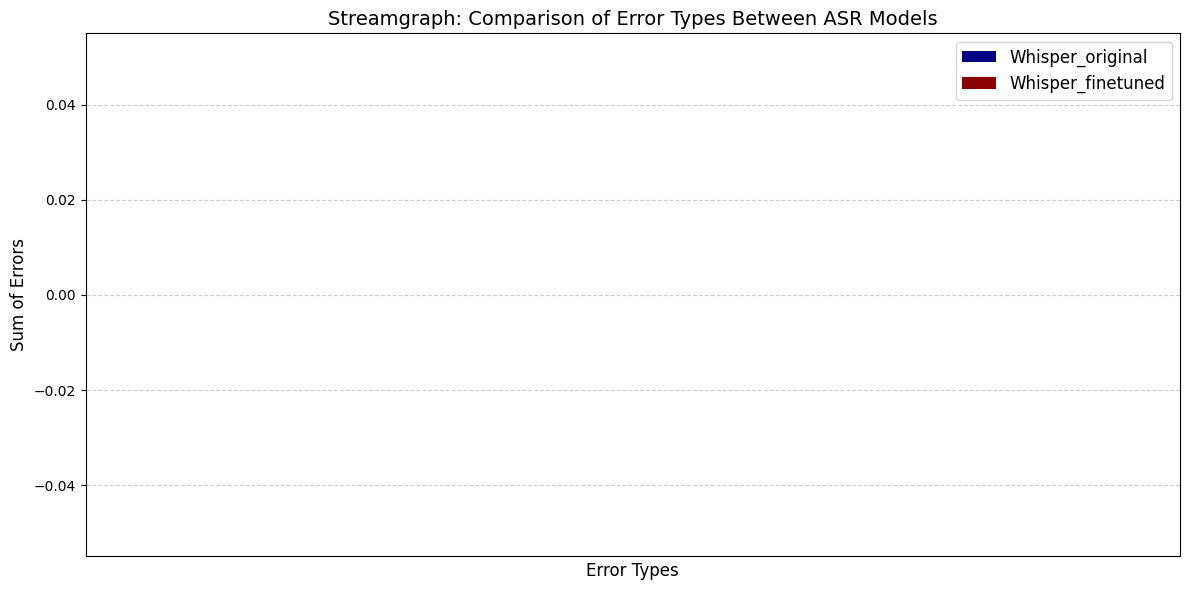

In [98]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Filter error_types to include only those present in both model scores and error_weights
common_error_types = [et for et in error_types if et in weights and et in model_1_scores and et in model_2_scores]

# Map error types to their corresponding scores using dictionaries
model_1_dict = dict(zip(error_types, model_1_scores))
model_2_dict = dict(zip(error_types, model_2_scores))

# Filter model scores and weights based on the common error types
model_1_filtered = [model_1_dict.get(et, 0) for et in common_error_types]
model_2_filtered = [model_2_dict.get(et, 0) for et in common_error_types]
weights_filtered = [weights.get(et, 0) for et in common_error_types]

# Ensure all arrays have the same length
n = len(common_error_types)
if not (len(model_1_filtered) == len(model_2_filtered) == len(weights_filtered) == n):
    raise ValueError("Data mismatch: Check error_types, model scores, and error weights.")

# Prepare DataFrame
data = pd.DataFrame({
    'Error Types': np.tile(common_error_types, 2),
    'Sum of Errors': np.concatenate([model_1_filtered, model_2_filtered]),
    'Model': [label_model_1] * n + [label_model_2] * n,
    'Weights': np.tile(weights_filtered, 2)
})

# Prepare for streamgraph
stream_data = pd.DataFrame({
    'Error Types': common_error_types,
    label_model_1: model_1_filtered,
    label_model_2: model_2_filtered
})

fig, ax = plt.subplots(figsize=(12, 6))
colors = ['navy', 'darkred']

ax.stackplot(
    np.arange(n),  # Use index values instead of categorical labels
    stream_data[label_model_1],
    stream_data[label_model_2],
    labels=[label_model_1, label_model_2],
    colors=colors
)

ax.set_xlabel('Error Types', fontsize=12)
ax.set_ylabel('Sum of Errors', fontsize=12)
ax.set_title('Streamgraph: Comparison of Error Types Between ASR Models', fontsize=14)
ax.legend(loc='upper right', fontsize=12)

ax.set_xticks(np.arange(n))
ax.set_xticklabels(common_error_types, rotation=45, ha='right', fontsize=10)

fig.tight_layout()
ax.grid(axis='y', linestyle='--', alpha=0.6)

plt.show()


In [99]:
import plotly.express as px
import pandas as pd
import numpy as np

# Filter only error types that exist in both error_weights and model scores
common_error_types = [et for et in error_types if et in weights and et in model_1_scores and et in model_2_scores]

# Create dictionaries for scores
model_1_dict = dict(zip(error_types, model_1_scores))
model_2_dict = dict(zip(error_types, model_2_scores))

# Filter model scores and weights accordingly
model_1_filtered = [model_1_dict[et] for et in common_error_types]
model_2_filtered = [model_2_dict[et] for et in common_error_types]
weights_filtered = [weights[et] for et in common_error_types]

# Ensure all arrays have the same length
n = len(common_error_types)
if not (len(model_1_filtered) == len(model_2_filtered) == len(weights_filtered) == n):
    raise ValueError("Data mismatch: Check error_types, model scores, and error weights.")

# Prepare DataFrame
data = pd.DataFrame({
    'Error Types': np.tile(common_error_types, 2),
    'Sum of Errors': np.concatenate([model_1_filtered, model_2_filtered]),
    'Model': [label_model_1] * n + [label_model_2] * n,
    'Weights': np.tile(weights_filtered, 2)
})

# Sunburst Chart erstellen
fig = px.sunburst(
    data,
    path=['Model', 'Error Types'],
    values='Sum of Errors',
    color='Model',
    color_discrete_map={label_model_1: 'navy', label_model_2: 'darkred'},
    title='Sunburst Chart: Comparison of Error Types Between ASR Models'
)

fig.update_layout(
    font_size=10
)

fig.show()


In [96]:
import plotly.express as px
import pandas as pd
import numpy as np

# Annahmen:
#error_types = ["d1", "d2", "d3", "s1", "s2", "s3", "s4", "s5", "s6", "s7", "s8", "i1"]
#model_1_scores = [10, 20, 15, 10, 5, 25, 30, 20, 15, 10, 5, 10]
#model_2_scores = [15, 25, 10, 5, 20, 15, 10, 25, 30, 20, 15, 10]
#label_model_1 = "ASR Model A"
#label_model_2 = "ASR Model B"
#error_weights = {'d1': 2, 'd2': 8, 'd3': 8, 's1': 8, 's2': 9, 's3': 4, 's4': 2, 's5': 2, 's6': 5, 's7': 3, 's8': 1, 'i1': 10}

# Anzahl der Fehlerarten
n = len(error_types)

# Daten vorbereiten
data = pd.DataFrame({
    'Error Types': np.tile(error_types, 2),
    'Sum of Errors': np.concatenate([model_1_scores, model_2_scores]),
    'Model': [label_model_1] * n + [label_model_2] * n,
    'Weights': np.tile([error_weights[etype] for etype in error_types], 2)
})

# Sortieren der Daten nach Fehlertypen und Modellen
data = data.sort_values(by=['Error Types', 'Model'])

# Sunburst Chart erstellen
fig = px.sunburst(
    data,
    path=['Error Types', 'Model'],
    values='Sum of Errors',
    color='Model',
    color_discrete_map={label_model_1: 'navy', label_model_2: 'darkred'},
    title='Sunburst Chart: Comparison of Error Types Between ASR Models'
)

fig.update_layout(
    font_size=10
)

fig.show()

ValueError: All arrays must be of the same length

In [100]:
import plotly.express as px
import pandas as pd
import numpy as np

# Annahmen:
#error_types = ["d1", "d2", "d3", "s1", "s2", "s3", "s4", "s5", "s6", "s7", "s8", "i1"]
#model_1_scores = [10, 20, 15, 10, 5, 25, 30, 20, 15, 10, 5, 10]
#model_2_scores = [15, 25, 10, 5, 20, 15, 10, 25, 30, 20, 15, 10]
#label_model_1 = "ASR Model A"
#label_model_2 = "ASR Model B"

# Gesamtsumme der Fehler f√ºr jedes Modell berechnen
total_errors_model_1 = sum(model_1_scores)
total_errors_model_2 = sum(model_2_scores)

# Daten vorbereiten
data = pd.DataFrame({
    'Model': [label_model_1, label_model_2],
    'Total Errors': [total_errors_model_1, total_errors_model_2]
})

# Balkendiagramm erstellen
fig = px.bar(
    data,
    x='Model',
    y='Total Errors',
    color='Model',
    color_discrete_map={label_model_1: 'navy', label_model_2: 'darkred'},
    title='Total Errors Comparison Between ASR Models'
)

fig.update_layout(
    font_size=10,
    xaxis_title='Model',
    yaxis_title='Total Errors'
)

fig.show()

In [101]:
import plotly.express as px
import pandas as pd
import numpy as np

# Annahmen:
#error_types = ["d1", "d2", "d3", "s1", "s2", "s3", "s4", "s5", "s6", "s7", "s8", "i1"]
#model_1_scores = [10, 20, 15, 10, 5, 25, 30, 20, 15, 10, 5, 10]
#model_2_scores = [15, 25, 10, 5, 20, 15, 10, 25, 30, 20, 15, 10]
#label_model_1 = "ASR Model A"
#label_model_2 = "ASR Model B"

# Daten vorbereiten
data = pd.DataFrame({
    'Error Types': np.tile(error_types, 2),
    'Sum of Errors': np.concatenate([model_1_scores, model_2_scores]),
    'Model': [label_model_1] * len(error_types) + [label_model_2] * len(error_types)
})

# Gestapeltes Balkendiagramm erstellen
fig = px.bar(
    data,
    x='Model',
    y='Sum of Errors',
    color='Error Types',
    barmode='stack',
    title='Stacked Bar Chart: Comparison of Total Errors Between ASR Models'
)

fig.update_layout(
    font_size=10,
    xaxis_title='Model',
    yaxis_title='Total Errors',
    legend_title='Error Types'
)

fig.show()

ValueError: All arrays must be of the same length

In [102]:
import plotly.express as px
import pandas as pd
import numpy as np

# Annahmen:
#error_types = ["d1", "d2", "d3", "s1", "s2", "s3", "s4", "s5", "s6", "s7", "s8", "i1"]
#model_1_scores = [10, 20, 15, 10, 5, 25, 30, 20, 15, 10, 5, 10]
#model_2_scores = [15, 25, 10, 5, 20, 15, 10, 25, 30, 20, 15, 10]
#label_model_1 = "ASR Model A"
#label_model_2 = "ASR Model B"

# Daten vorbereiten
data = pd.DataFrame({
    'Error Types': np.tile(error_types, 2),
    'Sum of Errors': np.concatenate([model_1_scores, model_2_scores]),
    'Model': [label_model_1] * len(error_types) + [label_model_2] * len(error_types)
})

# Bubble Chart erstellen
fig = px.scatter(
    data,
    x='Error Types',
    y='Sum of Errors',
    size='Sum of Errors',
    color='Model',
    symbol='Model',
    hover_name='Error Types',
    title='Bubble Chart: Comparison of Total Errors Between ASR Models',
    labels={'Sum of Errors': 'Total Errors'},
    size_max=60
)

fig.update_layout(
    font_size=10,
    xaxis_title='Error Types',
    yaxis_title='Total Errors',
    legend_title='Model'
)

fig.show()

ValueError: All arrays must be of the same length

In [ ]:
import plotly.express as px
import plotly.graph_objects as go
import pandas as pd
import numpy as np

# Annahmen:
#error_types = ["d1", "d2", "d3", "s1", "s2", "s3", "s4", "s5", "s6", "s7", "s8", "i1"]
#model_1_scores = [10, 20, 15, 10, 5, 25, 30, 20, 15, 10, 5, 10]
#model_2_scores = [15, 25, 10, 5, 20, 15, 10, 25, 30, 20, 15, 10]
#label_model_1 = "ASR Model A"
#label_model_2 = "ASR Model B"

# Daten vorbereiten
data = pd.DataFrame({
    'Error Types': np.tile(error_types, 2),
    'Sum of Errors': np.concatenate([model_1_scores, model_2_scores]),
    'Model': [label_model_1] * len(error_types) + [label_model_2] * len(error_types)
})

# Bubble Chart erstellen
fig = px.scatter(
    data,
    x='Error Types',
    y='Sum of Errors',
    size='Sum of Errors',
    color='Model',
    symbol='Model',
    hover_name='Error Types',
    title='Bubble Chart: Comparison of Total Errors Between ASR Models',
    labels={'Sum of Errors': 'Total Errors'},
    size_max=60
)

# Linien hinzuf√ºgen
for model, color in zip([label_model_1, label_model_2], ['navy', 'darkred']):
    model_data = data[data['Model'] == model]
    fig.add_trace(go.Scatter(
        x=model_data['Error Types'],
        y=model_data['Sum of Errors'],
        mode='lines',
        line=dict(color=color),
        name=f'{model} Line'
    ))

fig.update_layout(
    font_size=10,
    xaxis_title='Error Types',
    yaxis_title='Total Errors',
    legend_title='Model'
)

fig.show()

In [103]:
import plotly.express as px
import plotly.graph_objects as go
import pandas as pd
import numpy as np

# Annahmen:
#error_types = ["d1", "d2", "d3", "s1", "s2", "s3", "s4", "s5", "s6", "s7", "s8", "i1"]
#model_1_scores = [10, 20, 15, 10, 5, 25, 30, 20, 15, 10, 5, 10]
#model_2_scores = [15, 25, 10, 5, 20, 15, 10, 25, 30, 20, 15, 10]
#label_model_1 = "ASR Model A"
#label_model_2 = "ASR Model B"
#error_weights = {'d1': 2, 'd2': 8, 'd3': 8, 's1': 8, 's2': 9, 's3': 4, 's4': 2, 's5': 2, 's6': 5, 's7': 3, 's8': 1, 'i1': 10}

# Anzahl der Fehlerarten
n = len(error_types)

# Daten vorbereiten
data = pd.DataFrame({
    'Error Types': np.tile(error_types, 2),
    'Sum of Errors': np.concatenate([model_1_scores, model_2_scores]),
    'Model': [label_model_1] * n + [label_model_2] * n,
    'Weights': np.tile([error_weights[etype] for etype in error_types], 2)
})

# Bubble Chart erstellen
fig = px.scatter(
    data,
    x='Error Types',
    y='Sum of Errors',
    size='Weights',
    color='Model',
    symbol='Model',
    hover_name='Error Types',
    title='Bubble Chart: Comparison of Total Errors Between ASR Models with Weights',
    labels={'Sum of Errors': 'Total Errors'},
    size_max=60
)

# Linien hinzuf√ºgen
for model, color in zip([label_model_1, label_model_2], ['navy', 'darkred']):
    model_data = data[data['Model'] == model]
    fig.add_trace(go.Scatter(
        x=model_data['Error Types'],
        y=model_data['Sum of Errors'],
        mode='lines',
        line=dict(color=color),
        name=f'{model} Line'
    ))

fig.update_layout(
    font_size=10,
    xaxis_title='Error Types',
    yaxis_title='Total Errors',
    legend_title='Model'
)

fig.show()

ValueError: All arrays must be of the same length

In [104]:
import plotly.express as px
import plotly.graph_objects as go
import pandas as pd
import numpy as np

# Annahmen:
#error_types = ["d1", "d2", "d3", "s1", "s2", "s3", "s4", "s5", "s6", "s7", "s8", "i1"]
#model_1_scores = [10, 20, 15, 10, 5, 25, 30, 20, 15, 10, 5, 10]
#model_2_scores = [15, 25, 10, 5, 20, 15, 10, 25, 30, 20, 15, 10]
#label_model_1 = "ASR Model A"
#label_model_2 = "ASR Model B"
#error_weights = {'d1': 2, 'd2': 8, 'd3': 8, 's1': 8, 's2': 9, 's3': 4, 's4': 2, 's5': 2, 's6': 5, 's7': 3, 's8': 1, 'i1': 10}

# Anzahl der Fehlerarten
n = len(error_types)

# Daten vorbereiten
data = pd.DataFrame({
    'Error Types': np.tile(error_types, 2),
    'Sum of Errors': np.concatenate([model_1_scores, model_2_scores]),
    'Model': [label_model_1] * n + [label_model_2] * n,
    'Weights': np.tile([error_weights[etype] for etype in error_types], 2)
})

# Bubble Chart erstellen
fig = px.scatter(
    data,
    x='Error Types',
    y='Sum of Errors',
    size='Sum of Errors',
    color='Weights',
    color_continuous_scale='Viridis',
    symbol='Model',
    hover_name='Error Types',
    title='Bubble Chart: Comparison of Total Errors Between ASR Models with Weights',
    labels={'Sum of Errors': 'Total Errors'},
    size_max=60
)

# Linien hinzuf√ºgen
for model, color in zip([label_model_1, label_model_2], ['navy', 'darkred']):
    model_data = data[data['Model'] == model]
    fig.add_trace(go.Scatter(
        x=model_data['Error Types'],
        y=model_data['Sum of Errors'],
        mode='lines',
        line=dict(color=color),
        name=f'{model} Line'
    ))

fig.update_layout(
    font_size=10,
    xaxis_title='Error Types',
    yaxis_title='Total Errors',
    legend_title='Model'
)

fig.show()

ValueError: All arrays must be of the same length

In [105]:
import plotly.graph_objects as go
import numpy as np
import pandas as pd

# Annahmen auskommentiert lassen
#error_types = ["d1", "d2", "d3", "s1", "s2", "s3", "s4", "s5", "s6", "s7", "s8", "i1"]
#model_1_scores = [10, 20, 15, 10, 5, 25, 30, 20, 15, 10, 5, 10]
#model_2_scores = [15, 25, 10, 5, 20, 15, 10, 25, 30, 20, 15, 10]
#label_model_1 = "ASR Model A"
#label_model_2 = "ASR Model B" 
#error_weights = {'d1': 2, 'd2': 8, 'd3': 8, 's1': 8, 's2': 9, 's3': 4, 's4': 2, 's5': 2, 's6': 5, 's7': 3, 's8': 1, 'i1': 10}

# Calculate angles for radial layout
theta = np.linspace(0, 2*np.pi, len(error_types), endpoint=False)
r_base = 1

# Create radial coordinates
x1 = r_base * np.cos(theta) 
y1 = r_base * np.sin(theta)
x2 = 1.5 * r_base * np.cos(theta)
y2 = 1.5 * r_base * np.sin(theta)

# Create figure
fig = go.Figure()

# Add connecting tubes between models
for i in range(len(error_types)):
    fig.add_trace(go.Scatter3d(
        x=[x1[i], x2[i]],
        y=[y1[i], y2[i]],
        z=[model_1_scores[i], model_2_scores[i]],
        mode='lines',
        line=dict(
            color=f'rgb({int(255*error_weights[error_types[i]]/10)},20,147)',
            width=5
        ),
        hoverinfo='skip'
    ))

# Add markers for Model 1
fig.add_trace(go.Scatter3d(
    x=x1,
    y=y1,
    z=model_1_scores,
    mode='markers+text',
    text=error_types,
    marker=dict(
        size=model_1_scores,
        color=list(error_weights.values()),
        colorscale='Viridis',
        opacity=0.8
    ),
    name=label_model_1
))

# Add markers for Model 2
fig.add_trace(go.Scatter3d(
    x=x2,
    y=y2,
    z=model_2_scores,
    mode='markers+text',
    text=error_types,
    marker=dict(
        size=model_2_scores,
        color=list(error_weights.values()),
        colorscale='Plasma',
        opacity=0.8
    ),
    name=label_model_2
))

# Update layout
fig.update_layout(
    title='3D Radial Error Comparison',
    scene = dict(
        xaxis_title='',
        yaxis_title='',
        zaxis_title='Error Magnitude',
        camera=dict(
            eye=dict(x=1.5, y=1.5, z=1.2)
        )
    ),
    showlegend=True,
    template='plotly_dark',
    scene_camera=dict(
        up=dict(x=0, y=0, z=1),
        center=dict(x=0, y=0, z=0),
        eye=dict(x=1.5, y=1.5, z=1.2)
    ),
    updatemenus=[{
        'buttons': [
            {
                'args': [None, {'frame': {'duration': 500, 'redraw': True},
                              'fromcurrent': True,
                              'transition': {'duration': 300, 'easing': 'quadratic-in-out'}}],
                'label': 'üîÑ Rotate',
                'method': 'animate'
            }
        ],
        'type': 'buttons'
    }]
)

# Add animation
frames = []
for t in np.linspace(0, 360, 180):
    frames.append(
        go.Frame(
            layout={
                'scene_camera': {
                    'eye': {'x': 1.5*np.cos(t/180*np.pi), 
                           'y': 1.5*np.sin(t/180*np.pi), 
                           'z': 1.2}
                }
            }
        )
    )
fig.frames = frames

fig.show()

IndexError: list index out of range

In [106]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import numpy as np

# Create subplot layout
fig = make_subplots(rows=1, cols=2, specs=[[{'type': 'scatter'}, {'type': 'scatterpolar'}]])

# Create particle flow visualization (left)
for i, error_type in enumerate(error_types):
    # Add flow lines
    fig.add_trace(
        go.Scatter(
            x=[0, 1],
            y=[model_1_scores[i], model_2_scores[i]],
            mode='lines',
            line=dict(
                width=error_weights[error_type],
                color=f'hsla({int(360*i/len(error_types))},70%,50%,0.6)'
            ),
            name=error_type
        ),
        row=1, col=1
    )
    
    # Add error markers
    fig.add_trace(
        go.Scatter(
            x=[0, 1],
            y=[model_1_scores[i], model_2_scores[i]],
            mode='markers',
            marker=dict(
                size=error_weights[error_type]*5,
                color=f'hsl({int(360*i/len(error_types))},70%,50%)'
            ),
            showlegend=False
        ),
        row=1, col=1
    )

# Create radar chart (right)
fig.add_trace(
    go.Scatterpolar(
        r=model_1_scores,
        theta=error_types,
        fill='toself',
        name=label_model_1
    ),
    row=1, col=2
)

fig.add_trace(
    go.Scatterpolar(
        r=model_2_scores,
        theta=error_types,
        fill='toself',
        name=label_model_2
    ),
    row=1, col=2
)

# Update layout
fig.update_layout(
    template='plotly_dark',
    title='Dynamic Error Flow Analysis',
    showlegend=True,
    height=700,
    polar=dict(
        radialaxis=dict(
            visible=True,
            range=[0, max(max(model_1_scores), max(model_2_scores))]
        )
    ),
    xaxis=dict(
        showticklabels=False,
        showgrid=False,
        zeroline=False
    ),
    yaxis=dict(
        title='Error Magnitude'
    )
)

fig.show()

IndexError: list index out of range

In [107]:
import plotly.graph_objects as go
import numpy as np

# Berechnung der prozentualen Verbesserungen
improvements = [(m1 - m2)/m1 * 100 for m1, m2 in zip(model_1_scores, model_2_scores)]

# Clamping-Funktion f√ºr den Hue-Wert, damit er nicht negativ oder >360 wird
def clamp_hue(hue_val):
    return max(0, min(360, hue_val))

# Durchschnittliche Verbesserung nur √ºber positive Werte
pos_improvements = [imp for imp in improvements if imp > 0]
avg_improvement = np.mean(pos_improvements) if pos_improvements else 0

fig = go.Figure()

for error, m1, m2, imp in zip(error_types, model_1_scores, model_2_scores, improvements):
    # X- und Y-Koordinaten f√ºr den "flie√üenden" √úbergang
    x = np.linspace(0, 1, 50)
    y = np.interp(x, [0, 1], [m1, m2])
    
    # Hue-Wert an den Verbesserungsgrad kn√ºpfen und clampen
    hue = clamp_hue(int(240 * imp / 100))

    fig.add_trace(go.Scatter(
        x=x,
        y=y,
        mode='lines',
        line=dict(
            width=error_weights[error] * 2,
            color=f'hsla({hue}, 70%, 50%, 0.6)'
        ),
        name=error,
        hovertemplate=f"Error Type: {error}<br>Reduction: {imp:.1f}%"
    ))

# Marker f√ºr Startpunkte (Whisper Small)
fig.add_trace(go.Scatter(
    x=[0]*len(error_types),
    y=model_1_scores,
    mode='markers',
    marker=dict(
        size=[val*5 for val in model_1_scores],
        color='rgba(255,0,0,0.8)',
        symbol='circle'
    ),
    name='Whisper Small'
))

# Marker f√ºr Endpunkte (PK Dec)
fig.add_trace(go.Scatter(
    x=[1]*len(error_types),
    y=model_2_scores,
    mode='markers',
    marker=dict(
        size=[val*5 for val in model_2_scores],
        color='rgba(0,255,0,0.8)',
        symbol='circle'
    ),
    name='PK Dec'
))

# Annotation f√ºr durchschnittliche Verbesserung
fig.add_annotation(
    text=f"Average Improvement: {avg_improvement:.1f}%",
    xref="paper", yref="paper",
    x=0.5, y=1.05,
    showarrow=False,
    font=dict(size=20, color="white"),
    bgcolor="rgba(0,0,0,0.8)"
)

fig.update_layout(
    title="Error Reduction Flow: Whisper Small ‚Üí PK Dec",
    template="plotly_dark",
    showlegend=True,
    height=800,
    xaxis=dict(
        ticktext=["Whisper Small", "PK Dec"],
        tickvals=[0, 1],
        showgrid=False
    ),
    yaxis=dict(title="Error Magnitude"),
    plot_bgcolor='rgba(0,0,0,0.8)'
)

fig.show()


In [108]:
import plotly.graph_objects as go
import numpy as np

# Define distinct colors for each error type
error_colors = {
    'd1': '#FF0000',  # Red
    'd2': '#00FF00',  # Green
    #'d3': '#0000FF',  # Blue
    's1': '#FF00FF',  # Magenta
    's2': '#FFFF00',  # Yellow
    #'s3': '#00FFFF',  # Cyan
    #'s4': '#FF8000',  # Orange
    'a1': '#8000FF',  # Purple
    's6': '#0080FF',  # Light Blue
    's7': '#FF0080',  # Pink
    'i1': '#80FF00',  # Lime
    'i2': '#FF8080'   # Light Red
}

# Create figure
fig = go.Figure()

# Add flow lines with distinct colors
for i, (error, m1, m2) in enumerate(zip(error_types, model_1_scores, model_2_scores)):
    imp = (m1 - m2)/m1 * 100
    x = np.linspace(0, 1, 50)
    y = np.interp(x, [0, 1], [m1, m2])
    
    fig.add_trace(go.Scatter(
        x=x,
        y=y,
        mode='lines',
        line=dict(
            width=error_weights[error]*2,
            color=error_colors[error]
        ),
        name=error,
        hovertemplate=f"Error Type: {error}<br>Weight: {error_weights[error]}<br>Reduction: {imp:.1f}%"
    ))

# Add markers for Whisper Small
fig.add_trace(go.Scatter(
    x=[0]*len(error_types),
    y=model_1_scores,
    mode='markers',
    marker=dict(
        size=[error_weights[et]*4 for et in error_types],
        color=[error_colors[et] for et in error_types],
        symbol='circle'
    ),
    name='Whisper Small'
))

# Add markers for PK Dec
fig.add_trace(go.Scatter(
    x=[1]*len(error_types),
    y=model_2_scores,
    mode='markers',
    marker=dict(
        size=[error_weights[et]*4 for et in error_types],
        color=[error_colors[et] for et in error_types],
        symbol='circle'
    ),
    name='PK Dec'
))

# Add improvement annotation
avg_improvement = np.mean([imp for imp in [(m1 - m2)/m1 * 100 for m1, m2 in zip(model_1_scores, model_2_scores)] if imp > 0])
fig.add_annotation(
    text=f"Average Improvement: {avg_improvement:.1f}%",
    xref="paper", yref="paper",
    x=0.5, y=1.05,
    showarrow=False,
    font=dict(size=20, color="white"),
    bgcolor="rgba(0,0,0,0.8)"
)

# Update layout
fig.update_layout(
    title="Weighted Error Reduction Flow: Whisper Small ‚Üí PK Dec",
    template="plotly_dark",
    showlegend=True,
    height=800,
    xaxis=dict(
        ticktext=["Whisper Small", "PK Dec"],
        tickvals=[0, 1],
        showgrid=False
    ),
    yaxis=dict(title="Error Magnitude"),
    plot_bgcolor='rgba(0,0,0,0.8)'
)

fig.show()

KeyError: 'd3'

In [109]:
import plotly.graph_objects as go
import numpy as np

# Calculate source, target and values for Sankey
sources = []
targets = []
values = []
labels = []
colors = []

# Add initial total node
total_start = sum(model_1_scores)
total_end = sum(model_2_scores)

# Create node structure
for i, error in enumerate(error_types):
    # Add connections from start to error types
    sources.append(0)  # from start
    targets.append(i + 1)  # to error type
    values.append(model_1_scores[i])
    
    # Add connections from error types to end
    sources.append(i + 1)  # from error type
    targets.append(len(error_types) + 1)  # to end
    values.append(model_2_scores[i])
    
# Create labels list
labels = ['Whisper Small'] + error_types + ['PK Dec']

# Create colors based on weights
max_weight = max(error_weights.values())
colors = ['blue'] + [f'rgb({int(255*error_weights[et]/max_weight)}, 20, {int(255*(1-error_weights[et]/max_weight))})' 
                     for et in error_types] + ['green']

# Create Sankey diagram
fig = go.Figure(data=[go.Sankey(
    node = dict(
        pad = 15,
        thickness = 20,
        line = dict(color = "black", width = 0.5),
        label = labels,
        color = colors
    ),
    link = dict(
        source = sources,
        target = targets,
        value = values
    )
)])

# Update layout
fig.update_layout(
    title_text="Error Flow and Reduction from Whisper Small to PK Dec",
    font_size=10,
    height=800,
)

# Add improvement annotation
improvement = ((total_start - total_end) / total_start * 100)
fig.add_annotation(
    text=f"Total Error Reduction: {improvement:.1f}%",
    xref="paper", yref="paper",
    x=0.5, y=1.05,
    showarrow=False,
    font=dict(size=20),
    bgcolor="rgba(0,0,0,0.8)"
)

fig.show()

IndexError: list index out of range

In [110]:
import plotly.graph_objects as go
import numpy as np

df_model_1 = pd.read_csv('small_eg_fzh_combined_v2_whisper_error_types.csv')
label_model_1 = 'whisper_small'

df_model_2 = pd.read_csv('small_pk_dec_error_types.csv')
label_model_2 = 'pk_dec'

df_error_types = pd.read_csv('error_types_new.csv')

filter_keys = ['wer', 'actual', 'target'] # 'Unnamed: 0', 'original', 'predictions', 
df_results_1  = df_model_1.drop(columns = filter_keys) 

filter_keys = ['wer','original', 'predictions']
df_results_2 = df_model_2.drop(columns = filter_keys)

(df_results_1['d1 warum']=='fehler').sum()
df_cleaned_1 = df_model_1[df_model_1["d1 warum"] != "fehler"]

# probability of error occurance
model_1_scores = []
model_2_scores = []
# df_cleaned = df[df['fehler'] != "error"]
for error in error_types:
    df_cleaned_1 = df_model_1[df_model_1[f"{error} warum"] != "fehler"]
    model_1_scores += [(df_cleaned_1[f"{error} p"]*df_cleaned_1[f"{error} N"]).sum()/ len(df_cleaned_1) ]
    
    df_cleaned_2 = df_model_2[df_model_2[f"{error} warum"] != "fehler"]
    model_2_scores += [(df_cleaned_2[f"{error} p"]*df_cleaned_2[f"{error} N"]).sum()/ len(df_cleaned_2) ]

# Define vibrant colors for error types
error_colors = {
    'd1': '#FF0000', 'd2': '#00FF00', 
    's1': '#FF00FF', 's2': '#FFFF00', 's6': '#00FFFF', 's7': '#FF8000',
    'a1': '#8000FF', 
    'i1': '#FF0080', 'i2': '#FF8080'
}

# Calculate reductions and create enhanced labels
reductions = {}
enhanced_labels = ['Whisper Small']
for error, m1, m2 in zip(error_types, model_1_scores, model_2_scores):
    red_pct = ((m1 - m2) / m1 * 100) if m1 > 0 else 0
    reductions[error] = red_pct
    enhanced_labels.append(f"{error}<br>({red_pct:.1f}%)")
enhanced_labels.append('PK Dec')

# Prepare Sankey data
sources = []
targets = []
values = []
link_colors = []

# Build node structure
for i, error in enumerate(error_types):
    # Start to error type
    sources.append(0)
    targets.append(i + 1)
    values.append(model_1_scores[i])
    link_colors.append(error_colors[error])
    
    # Error type to end
    sources.append(i + 1)
    targets.append(len(error_types) + 1)
    values.append(model_2_scores[i])
    link_colors.append(error_colors[error])

# Create node colors
node_colors = ['#1f77b4'] + [error_colors[et] for et in error_types] + ['#2ca02c']

# Create Sankey diagram
fig = go.Figure(data=[go.Sankey(
    node = dict(
        pad = 15,
        thickness = 20,
        line = dict(color = "black", width = 0.5),
        label = enhanced_labels,
        color = node_colors,
        hovertemplate = "Error Type: %{label}<br>Value: %{value}<extra></extra>"
    ),
    link = dict(
        source = sources,
        target = targets,
        value = values,
        color = link_colors,
        hovertemplate = "From: %{source.label}<br>To: %{target.label}<br>Value: %{value}<extra></extra>"
    )
)])

# Calculate and add total improvement annotation
total_start = sum(model_1_scores)
total_end = sum(model_2_scores)
improvement = ((total_start - total_end) / total_start * 100)
fig.add_annotation(
    text=f"Total Error Reduction: {improvement:.1f}%",
    xref="paper", yref="paper",
    x=0.5, y=1.05,
    showarrow=False,
    font=dict(size=20, color="black")
)

# Update layout
fig.update_layout(
    title_text="Error Flow and Reduction from Whisper Small to PK Dec",
    font_size=10,
    height=900,
    paper_bgcolor='white',
    plot_bgcolor='white'
)

fig.show()

KeyError: 'd3 warum'